<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [311]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [312]:
#1 look at columns and missing data and decide which features to keep
#2 determine fixed vs renovatable features
#3 analysize salesprice....look at distribution, mean, etc
#4 look at some other continuous variables
#5 try a heatmap
#6 drop some columns
#7

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [313]:
# Load the data
house = pd.read_csv('./housing.csv')


In [314]:
#delete non-residential data
mask = (house['MSZoning'] != 'C (all)')
residential= pd.DataFrame(house[mask])

In [315]:
#checking out the data to look at data types and look for null values
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [316]:
#clean the data by filling in the blank values
#clean the data
#fill in the numeric fields with 0 and either 'None' or 'NA' for the other values
residential['LotFrontage'].fillna(0,inplace = True)
residential['MasVnrType'].fillna('None',inplace = True)
residential['MasVnrArea'].fillna(0,inplace = True)
residential['GarageType'].fillna('NA',inplace =   True)
residential['GarageYrBlt'].fillna(0,inplace = True)
residential['BsmtExposure'].fillna('NA',inplace = True)
residential['Alley'].fillna('NA',inplace = True)
residential['BsmtQual'].fillna('NA',inplace =     True)

residential['BsmtCond'].fillna('NA',inplace =     True)
residential['BsmtFinType1'].fillna('NA',inplace = True)
residential['BsmtFinType2'].fillna('NA',inplace = True)
residential['GarageFinish'].fillna('NA',inplace = True)
residential['GarageQual'].fillna('NA',inplace =   True)
residential['GarageCond'].fillna('NA',inplace =   True)
residential['Electrical'].fillna('SBrkr',inplace = True)

In [317]:
residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [318]:
#determine continuous variables that I want to keep
continuous_list = [
'SalePrice',
'LotFrontage', #
'LotArea',
'MasVnrArea',
'TotalBsmtSF',#
'GrLivArea',
'GarageArea', #
'PoolArea',
'TotSF'

]



In [319]:
residential['TotSF']=residential['1stFlrSF']+ residential['2ndFlrSF']

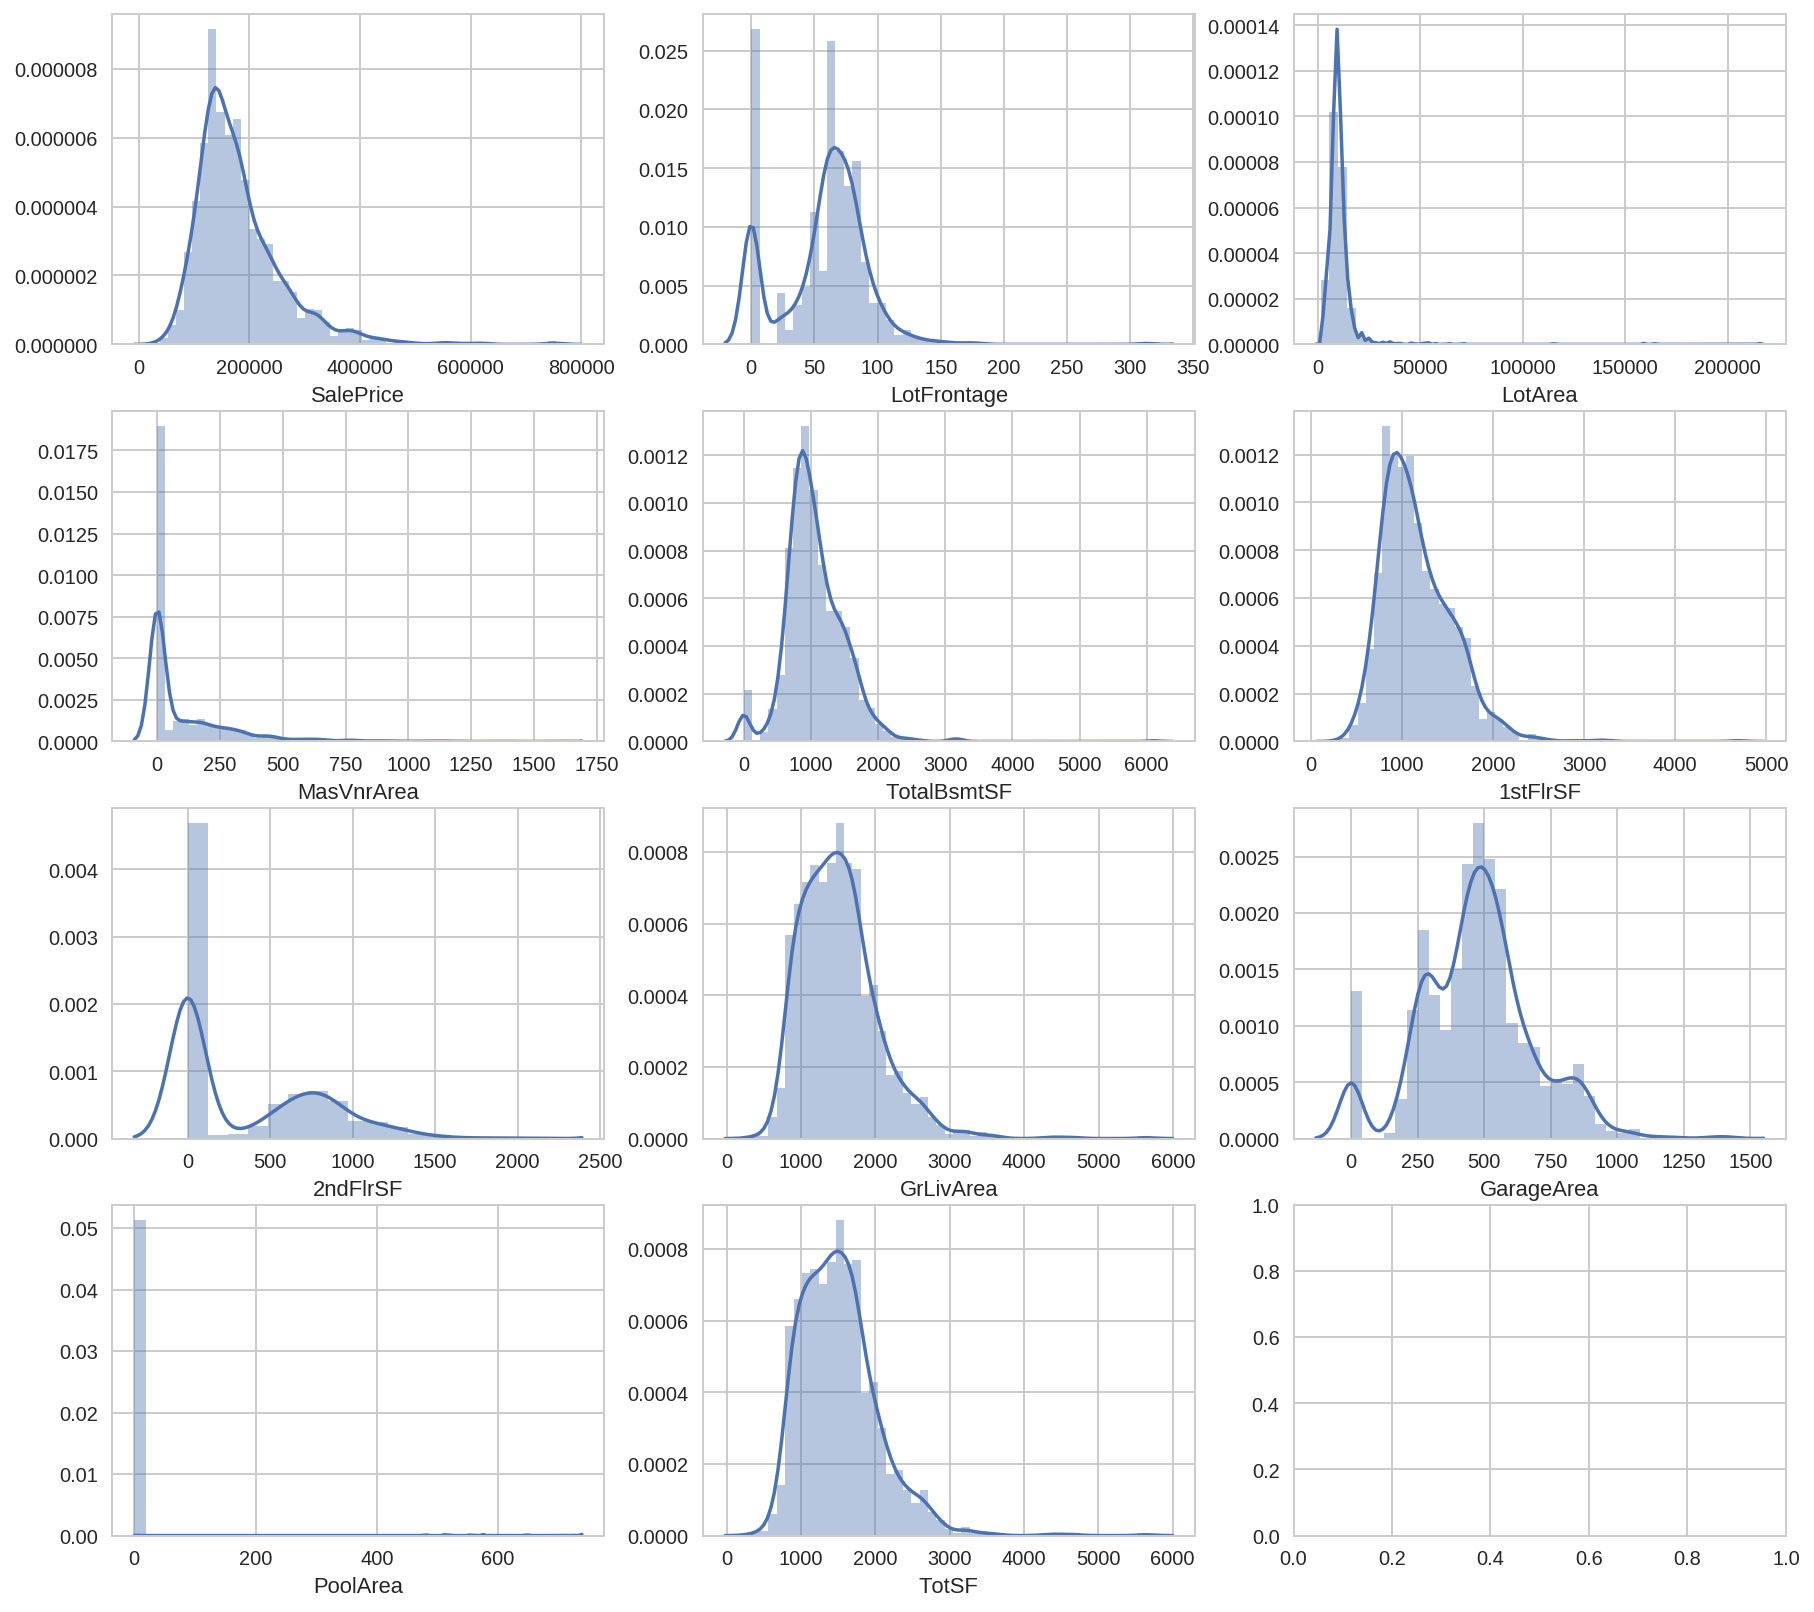

In [320]:
#plot distribution plots for my continuous variables
fig, ax = plt.subplots(4,3,figsize=(15,14))
sns.distplot(residential['SalePrice'], ax= ax[0,0])
sns.distplot(residential['LotFrontage'], ax= ax[0,1])
sns.distplot(residential['LotArea'], ax= ax[0,2])

sns.distplot(residential['MasVnrArea'], ax= ax[1,0])
sns.distplot(residential['TotalBsmtSF'], ax= ax[1,1])
sns.distplot(residential['1stFlrSF'], ax= ax[1,2])

sns.distplot(residential['2ndFlrSF'], ax= ax[2,0])
sns.distplot(residential['GrLivArea'], ax= ax[2,1])
sns.distplot(residential['GarageArea'], ax= ax[2,2])

sns.distplot(residential['PoolArea'], ax= ax[3,0])
sns.distplot(residential['TotSF'],ax = ax[3,1])

In [321]:
#checking skew in my continuous variables
for col in continuous_list:    print('{} skew test: {}'.format(col, st.skewtest(residential[col])))


SalePrice skew test: SkewtestResult(statistic=20.275141281233395, pvalue=2.1317890687126683e-91)
LotFrontage skew test: SkewtestResult(statistic=4.1396424861809269, pvalue=3.4784749482996889e-05)
LotArea skew test: SkewtestResult(statistic=43.555082414632395, pvalue=0.0)
MasVnrArea skew test: SkewtestResult(statistic=24.31315202334855, pvalue=1.4231718249905886e-130)
TotalBsmtSF skew test: SkewtestResult(statistic=17.647396962755927, pvalue=1.0655556291349257e-69)
GrLivArea skew test: SkewtestResult(statistic=16.510424801814398, pvalue=3.0870265842557448e-61)
GarageArea skew test: SkewtestResult(statistic=2.5239329301622688, pvalue=0.011605006727375028)
PoolArea skew test: SkewtestResult(statistic=46.039187129608486, pvalue=0.0)
TotSF skew test: SkewtestResult(statistic=16.214919314198703, pvalue=3.9559679210865659e-59)


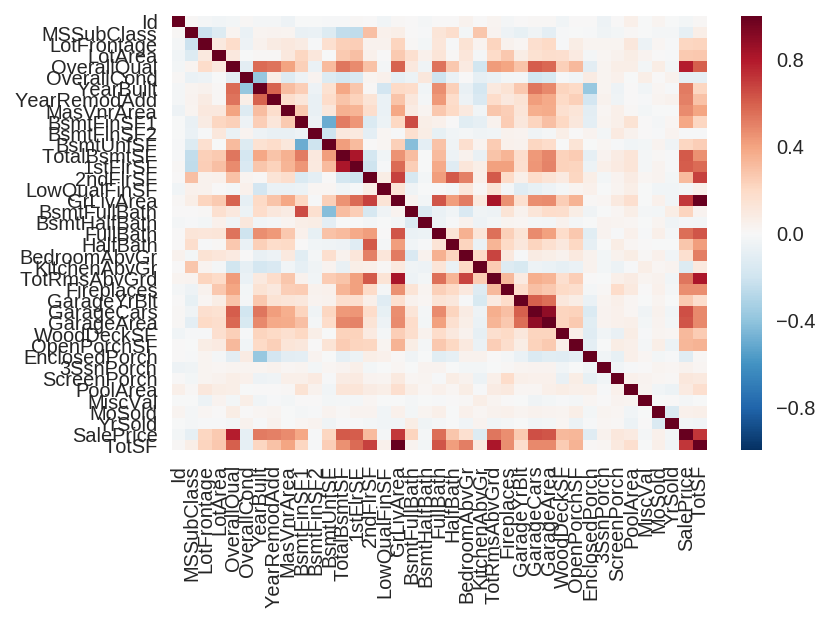

In [322]:
sns.heatmap(residential.corr())

In [323]:
#All the continuous variables look to be badly skewed.

#SalePrice, LotArea, 1stFlrSF, TotalBsmtSF,GrLivArea columns looks like maybe affected by outlier. 
#Will do some boxplots next to check

#PoolArea and MasVnrArea have horrible distribution and probably not very useful for determining price so I'm going
#to drop those columns

#LotFrontage and GarageArea and 2ndFlrSF have Multi-Modal distribution.  I will drop the LotFrontage and GarageArea
#columns because I think I can get similar information using LotArea and GarageCars column

#for 2ndFlrSF and 1stFlrSF I am going to sum the 2 square footage together and consider total Square Footage(TotSF)

#Fence 
#PoolQC
#MiscFeature
#MiscVal
#FireplaceQu
#YearBuilt
#LandSlope

#YearBuilt-same information contained in the YearRemodAdd column unless house has been remodeled, in which I want to know
#the remodeled year instead of built year anyway
#LandSlope-Land contour gives similar information
#Id

In [324]:
#drop unwanted columns
#going to try and keep yearbuilt and  yearremodel 'YearBuilt','YearRemodAdd', 'LotFrontage','GarageArea',

#residential.drop(['PoolArea','MasVnrArea', 'Fence', 'GarageArea', \
#                  'PoolQC','MiscFeature','MiscVal','FireplaceQu','LandSlope', \
#                 '1stFlrSF','2ndFlrSF','Id'], axis = 1, inplace = True)

In [325]:
residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotSF
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1710
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1262
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1786
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1717
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,2198


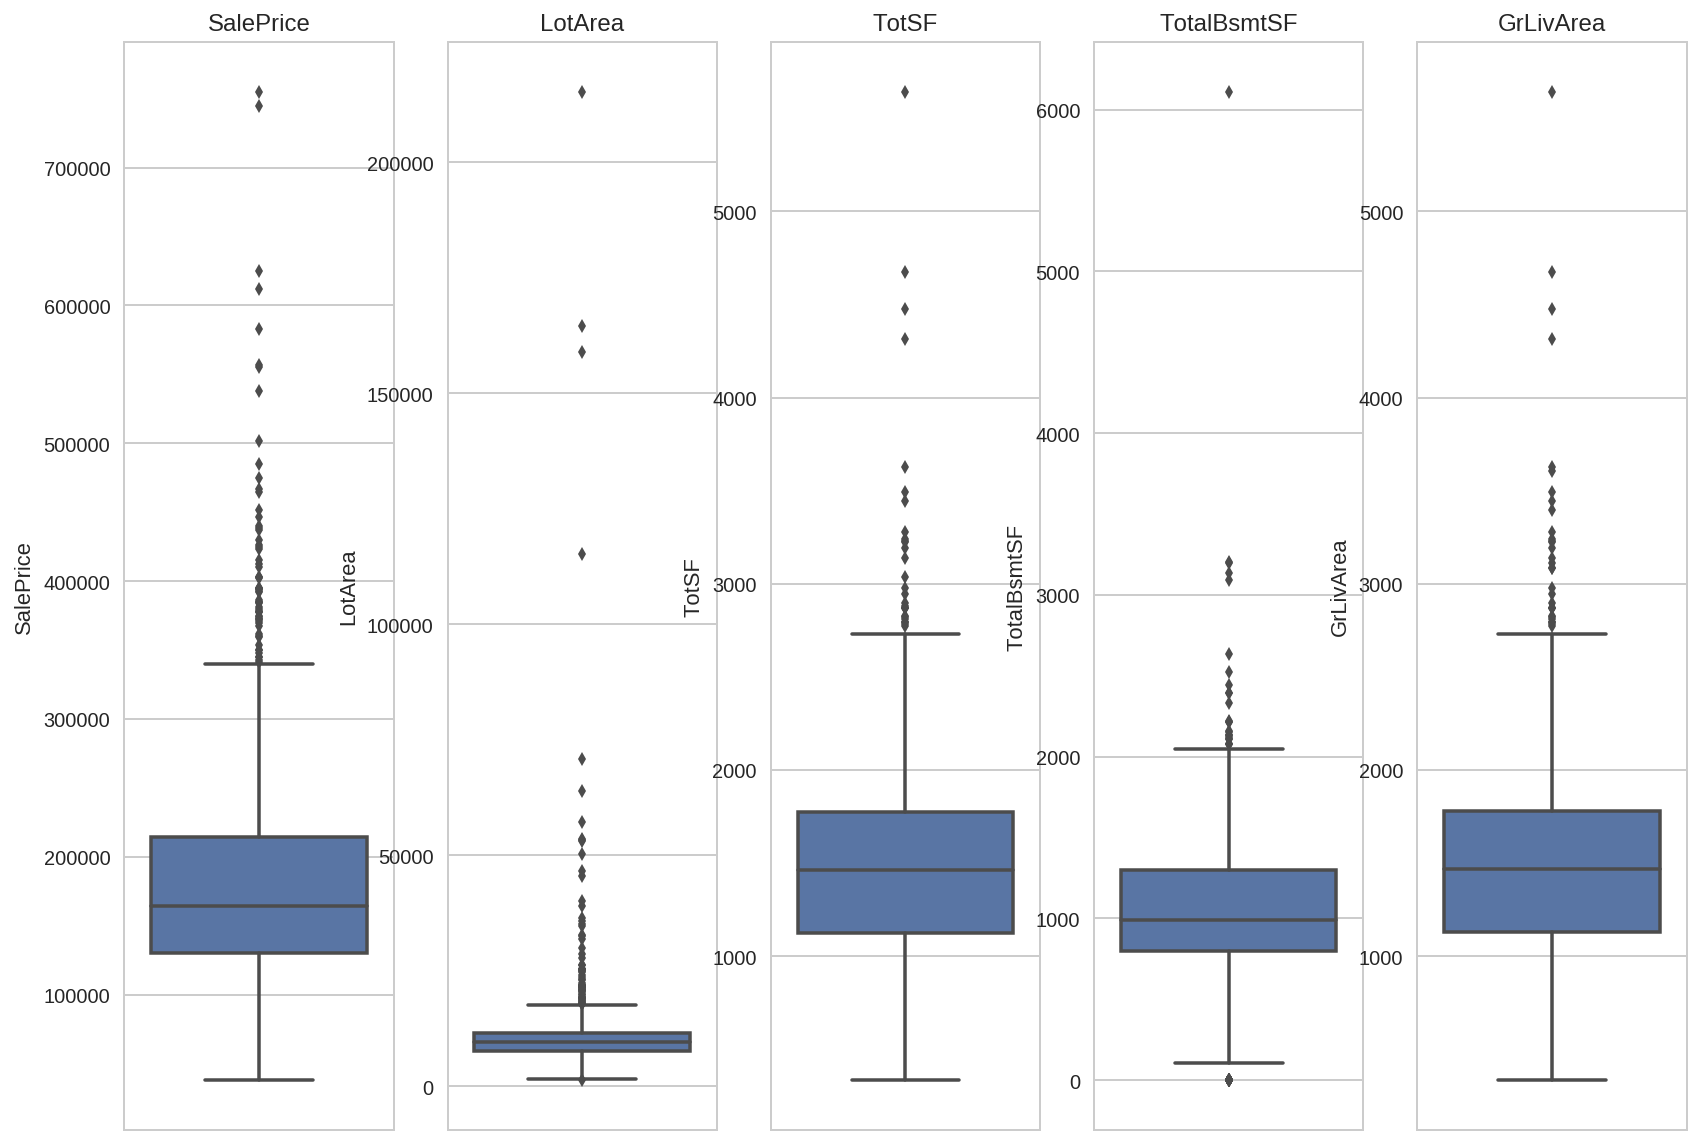

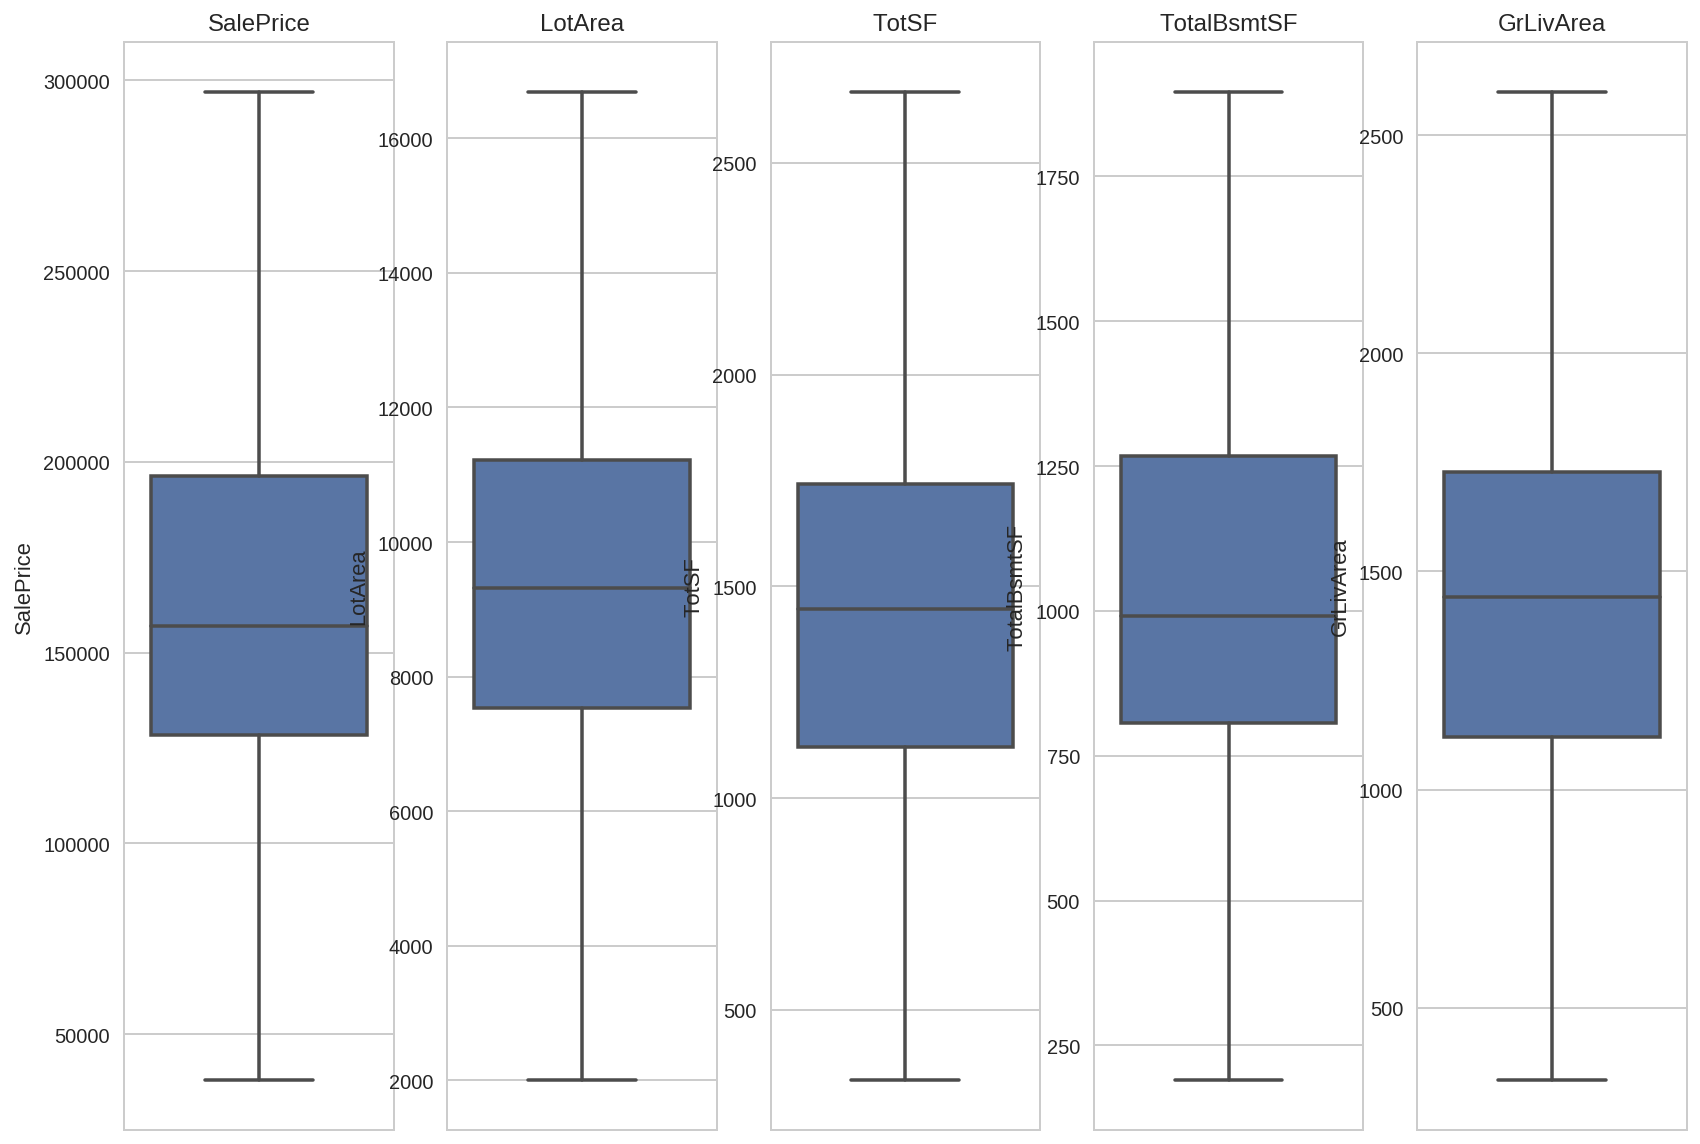

In [326]:
#make some boxplots on 'SalePrice', 'LotArea', 'TotSF','TotalBsmtSF', 'GrLivArea' to check for outliers
fig = plt.figure(figsize=(14,10))
fig.add_subplot(151)
plt.title("SalePrice")
sns.boxplot(y= residential['SalePrice'])
fig.add_subplot(152)
plt.title("LotArea")
sns.boxplot(y= residential['LotArea'])
fig.add_subplot(153)
plt.title("TotSF")
sns.boxplot(y= residential['TotSF'])
fig.add_subplot(154)
plt.title("TotalBsmtSF")
sns.boxplot(y= residential['TotalBsmtSF'])
fig.add_subplot(155)
plt.title("GrLivArea")
sns.boxplot(y= residential['GrLivArea'])

#mask0= (residential['TotalBsmtSF']!=0)
mask1 = (residential['SalePrice']<299000)
mask2 = ( (residential['LotArea'] < 16700) & (residential['LotArea'] >2000))
mask3 = (residential['TotSF']<2680)
mask4 = ( (residential['TotalBsmtSF'] < 1900) & (residential['TotalBsmtSF'] > 105))
mask5 = (residential['GrLivArea'] < 2600)
fig2 = plt.figure(figsize=(14,10))
fig2.add_subplot(151)
plt.title("SalePrice")
sns.boxplot(y= residential[mask1]['SalePrice'])
fig2.add_subplot(152)
plt.title("LotArea")
sns.boxplot(y= residential[mask2]['LotArea'])
fig2.add_subplot(153)
plt.title("TotSF")
sns.boxplot(y= residential[mask3]['TotSF'])
fig2.add_subplot(154)
plt.title("TotalBsmtSF")
sns.boxplot(y= residential[mask4]['TotalBsmtSF'])
fig2.add_subplot(155)
plt.title("GrLivArea")
sns.boxplot(y= residential[mask5]['GrLivArea'])

In [327]:
#trying to get an idea of how many rows are in the outliers


print(residential[~mask1].shape)
print(residential[~mask2].shape)
print(residential[~mask3].shape)
print(residential[~mask4].shape)
print(residential[~mask5].shape)
#37 rows for no basement so just going to drop them
#the rest doesn't look too bad so going to drop them too

(116, 82)
(106, 82)
(37, 82)
(84, 82)
(53, 82)


In [328]:
#mask0 through mask5 above removes all the outliers.  
#residential = pd.DataFrame(residential[mask0])
#residential = pd.DataFrame(residential[mask1])
#residential = pd.DataFrame(residential[mask2])
#residential = pd.DataFrame(residential[mask3])
#residential = pd.DataFrame(residential[mask4])
#residential = pd.DataFrame(residential[mask5])

#residential = residential[mask1]
#residential = residential[mask2]
#residential = residential[mask3]
#residential = residential[mask4]
#residential = residential[mask5]

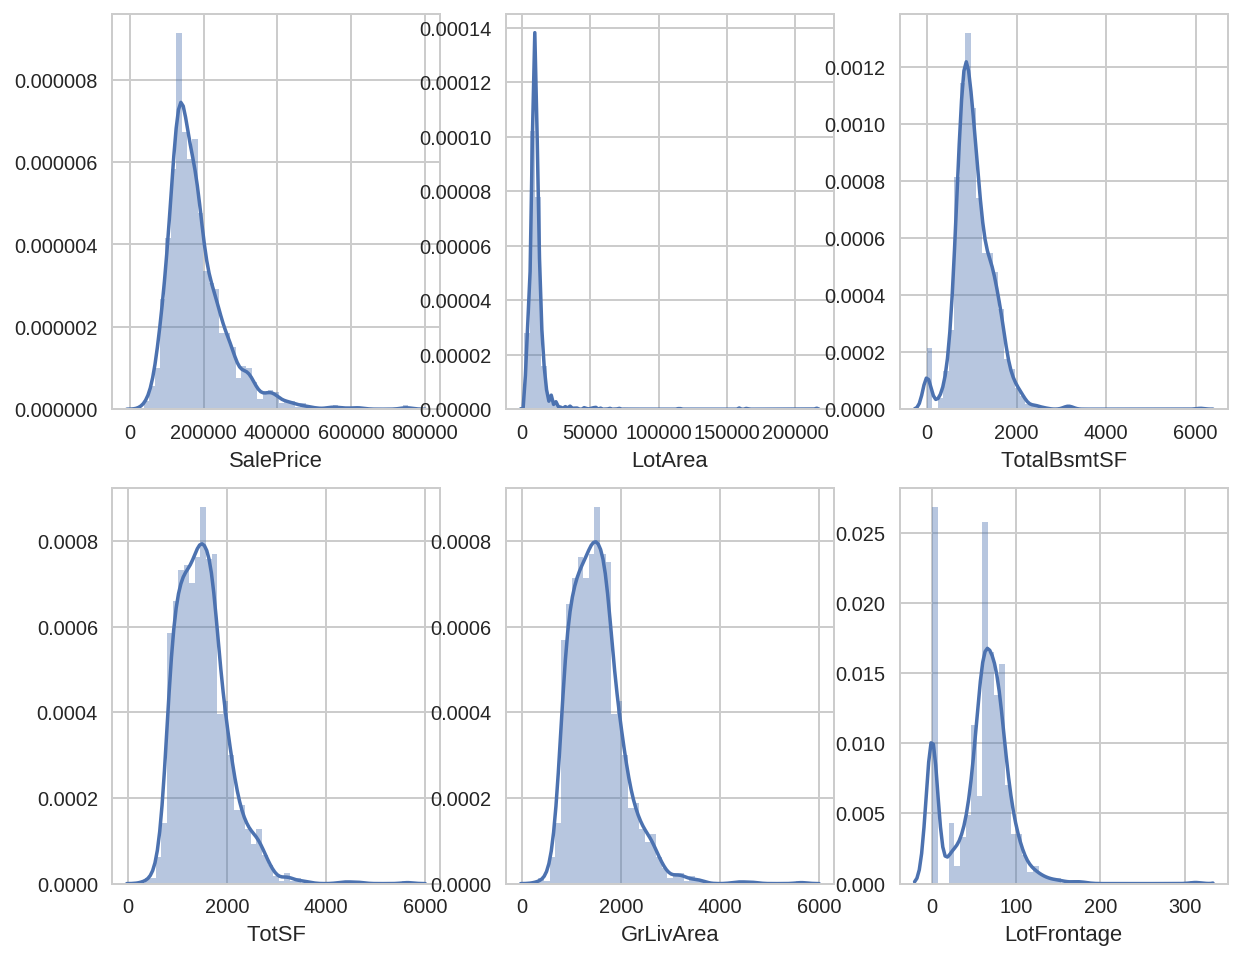

In [329]:
fig, ax = plt.subplots(2,3,figsize=(10,8))

sns.distplot(residential['SalePrice'], ax= ax[0,0])
sns.distplot(residential['LotArea'], ax= ax[0,1])
sns.distplot(residential['TotalBsmtSF'], ax= ax[0,2])

sns.distplot(residential['TotSF'], ax= ax[1,0])
sns.distplot(residential['GrLivArea'], ax= ax[1,1])
sns.distplot(residential['LotFrontage'], ax = ax[1,2])




In [330]:
#skew test again
continuous_list = [
'LotFrontage',
'GarageArea',
'SalePrice',
'LotArea',
'TotalBsmtSF',#
'TotSF',
'GrLivArea'

]
for col in continuous_list:    print('{} skew test: {}'.format(col, st.skewtest(residential[col])))


LotFrontage skew test: SkewtestResult(statistic=4.1396424861809269, pvalue=3.4784749482996889e-05)
GarageArea skew test: SkewtestResult(statistic=2.5239329301622688, pvalue=0.011605006727375028)
SalePrice skew test: SkewtestResult(statistic=20.275141281233395, pvalue=2.1317890687126683e-91)
LotArea skew test: SkewtestResult(statistic=43.555082414632395, pvalue=0.0)
TotalBsmtSF skew test: SkewtestResult(statistic=17.647396962755927, pvalue=1.0655556291349257e-69)
TotSF skew test: SkewtestResult(statistic=16.214919314198703, pvalue=3.9559679210865659e-59)
GrLivArea skew test: SkewtestResult(statistic=16.510424801814398, pvalue=3.0870265842557448e-61)


In [331]:
#8-8-2017....start from here on Wednesday.  Need to fix the fixed_features list and renovatable list
#then split into fixed and 2010 data, etc.

In [332]:
#Fixed Features
fixed_features = [
#'GarageArea',
'MSSubClass',
'MSZoning',
'LotArea',
'Street',
'Alley',
'LotShape',
'LandContour',
#'LotFrontage',
'LotConfig',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearBuilt',
'YearRemodAdd',
'RoofStyle',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'Foundation',
'BsmtQual',
'BsmtExposure',
'TotalBsmtSF',
'TotSF',
'GrLivArea',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageType',
'GarageYrBlt',
'GarageCars',
'MoSold',
'YrSold',
'SaleType',
'SaleCondition',
'SalePrice'
]

In [333]:
#renovatable Features

Renovatable_features = [
'Utilities',
'OverallQual',
'OverallCond',
'RoofMatl',
'ExterQual',
'ExterCond',
'BsmtCond',
'BsmtFinType1',
'BsmtFinType2',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'Heating',
'HeatingQC',
'CentralAir',
'Electrical',
'LowQualFinSF',
'KitchenQual',
'Functional',
'GarageQual',
'GarageCond',
'PavedDrive',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'SalePrice'
]

In [334]:
#do a log transform on SalePrice,TotalBsmtSF, TotSF, GrLivArea to try and de-skew the data.  LotArea excluded because 
#applying log seems to make the skew worse.

continuous_list = [
'SalePrice',
'LotArea',
'TotalBsmtSF',
'TotSF',
#'LotFrontage',
#'GarageArea',
'GrLivArea'

]

#for col in continuous_list:
    #box_cox_trans = st.boxcox(residential[col])[0]
    #residential[col]=pd.Series(box_cox_trans)
#    residential[col]=np.log(residential[col])
 #   print('{} skew test: {}'.format(col , st.skewtest(residential[col])))
print('{} skew test: {}'.format('LotArea' , st.skewtest(residential['LotArea'])))
print('{} skew test: {}'.format('LotFrontage' , st.skewtest(residential['LotFrontage'])))

LotArea skew test: SkewtestResult(statistic=43.555082414632395, pvalue=0.0)
LotFrontage skew test: SkewtestResult(statistic=4.1396424861809269, pvalue=3.4784749482996889e-05)


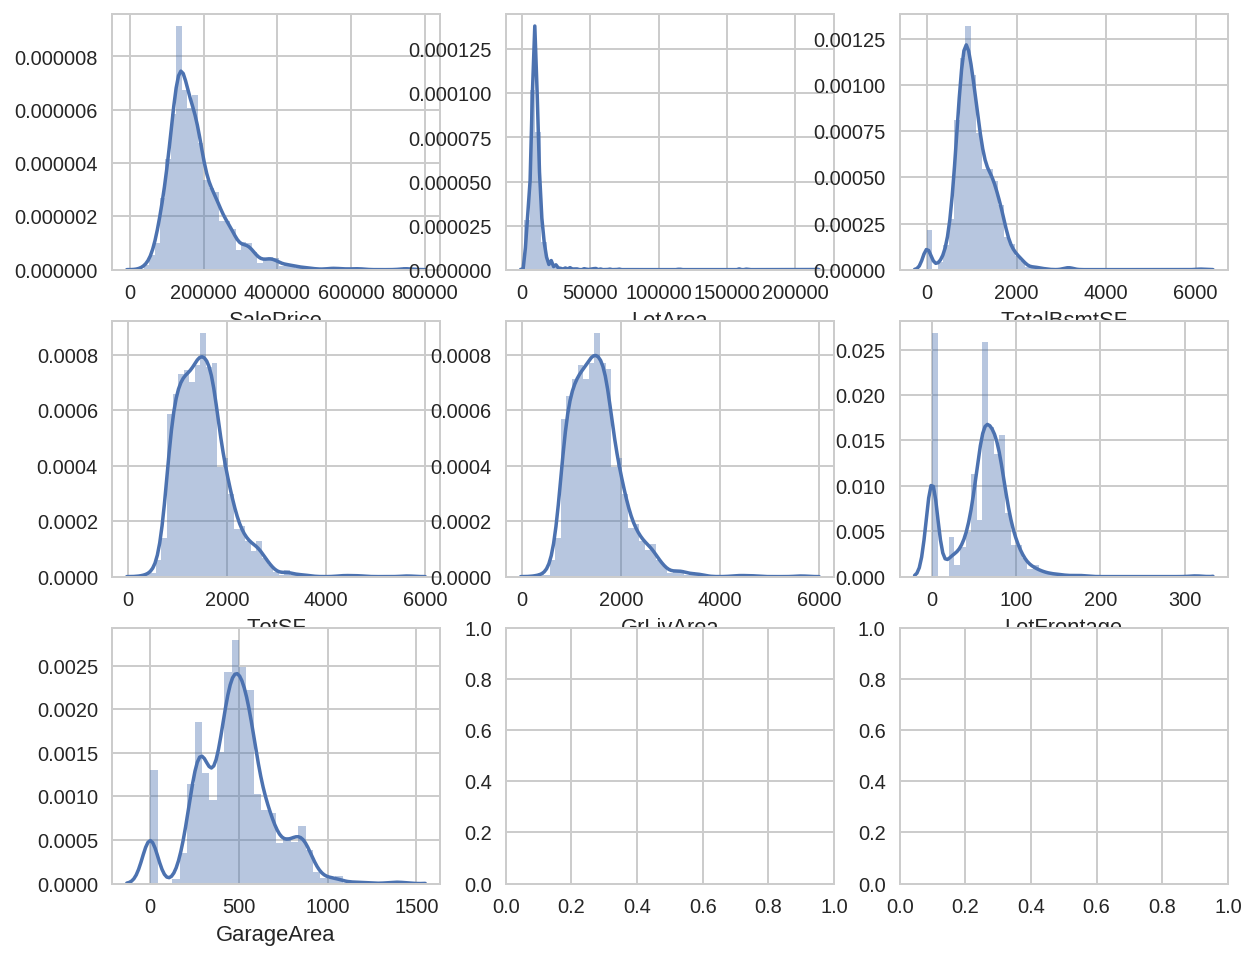

In [335]:
#Plot graphs again
fig, ax = plt.subplots(3,3,figsize=(10,8))

sns.distplot(residential['SalePrice'], ax= ax[0,0])
sns.distplot(residential['LotArea'], ax= ax[0,1])
sns.distplot(residential['TotalBsmtSF'], ax= ax[0,2])

sns.distplot(residential['TotSF'], ax= ax[1,0])
sns.distplot(residential['GrLivArea'], ax= ax[1,1])
sns.distplot(residential['LotFrontage'], ax = ax[1,2])
sns.distplot(residential['GarageArea'], ax = ax[2,0])

In [336]:
#create my fixed and renovatable dataframes
fixed = pd.DataFrame(residential[fixed_features])
renovatable = pd.DataFrame(residential[Renovatable_features])

In [337]:
#get dummies to transform categorical data
#get dummies
fixed_d = pd.get_dummies(fixed, columns = [
#'GarageArea',
'MSSubClass',
'MSZoning',
'Street',
'Alley',
'LotShape',
'LandContour',
'LotConfig',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearBuilt', 
'YearRemodAdd',
'RoofStyle',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'Foundation',
'BsmtQual',
'BsmtExposure',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageType',
'GarageYrBlt',
'GarageCars',
'MoSold',
'YrSold',
'SaleType',
'SaleCondition'

])

In [338]:
#splitting data into training and test set
mask = fixed_d['YrSold_2010']==1
fixed_test = pd.DataFrame(fixed_d[mask])
fixed_train =pd.DataFrame(fixed_d[~mask])
y_test = fixed_d[mask]['SalePrice']
y_train = fixed_d[~mask]['SalePrice']
fixed_test.drop(['SalePrice'], axis = 1, inplace=True)
fixed_train.drop(['SalePrice'], axis = 1, inplace=True)

In [339]:
#Build  GradientBoostingRegressor
gbr_pipe = Pipeline([
    ('gbr_scaler',StandardScaler()),
    ('gbr', GradientBoostingRegressor(n_estimators = 100, max_depth = 5))
])


In [234]:
#Build ExtraTreesRegressor
etr_pipe = Pipeline([
    ('etr_scaler', StandardScaler()),
    ('etr', ExtraTreesRegressor())
])
etr_params = {
    'etr__bootstrap':[False,True],
    'etr__n_estimators':[51,100,200,300]
}

In [167]:
etr_gs = GridSearchCV(etr_pipe, param_grid=etr_params, cv=5, n_jobs=-1)

In [168]:
etr_gs.fit(fixed_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('etr_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('etr', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'etr__bootstrap': [False, True], 'etr__n_estimators': [51, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [169]:
etr_gs.score(fixed_test,y_test)

0.80544660702758875

In [178]:
etr_gs.predict(fixed_test)

array([ 11.89233845,  11.89025552,  11.74902748,  12.04159283,
        11.78152799,  11.79812497,  11.79676222,  11.51789791,
        11.85324796,  11.7959773 ,  11.77951224,  11.50388797,
        11.74014598,  12.1431412 ,  12.15372228,  12.2781109 ,
        12.19541546,  12.05772976,  11.62838069,  11.7864393 ,
        12.29801605,  12.44212125,  12.35819198,  12.28182332,
        12.04326715,  12.07253899,  11.90991091,  11.70376403,
        11.81951813,  11.76843625,  12.31095897,  12.14010971,
        12.21455428,  11.80919597,  12.32368341,  12.32349625,
        11.46107044,  11.83192019,  11.8067494 ,  12.46558227,
        12.28839573,  11.65550277,  12.29543405,  11.54204718,
        11.52514895,  11.90394433,  11.91685777,  11.75471052,
        11.83796466,  12.09386434,  11.80514181,  12.34463789,
        11.55195046,  11.8457212 ,  12.20964382,  12.10519063,
        12.16855209,  12.27396508,  12.00315567,  11.75324384,
        12.2581603 ,  11.95486231,  11.87534067,  11.86

In [173]:
#Build RandomForestRegressor
rfr_pipe = Pipeline([
    ('rfr_scaler',StandardScaler()),
    ('rfr', RandomForestRegressor())
])
rfr_params = {
    'rfr__n_estimators':[100,200,250,300],
    'rfr__max_features':['auto','log2'],
    'rfr__max_depth':[3,4,5,6,7]
}


In [342]:
#fit GradientBoostingRegressor
gbr_pipe.fit(fixed_train, y_train)

Pipeline(steps=[('gbr_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
  ...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

In [343]:
#score GradientBoostingRegresor
gbr_pipe.score(fixed_test, y_test)

0.83780938171221275

In [177]:
gbr_pipe.predict(fixed_test)

array([ 11.86459129,  11.85205326,  11.77050058,  12.07566158,
        11.76363075,  11.76155953,  11.70843518,  11.42328366,
        11.89288752,  11.82842734,  11.81938348,  11.26893875,
        11.63578589,  12.11932666,  12.14791954,  12.12014684,
        12.2334184 ,  12.03516296,  11.52960191,  11.70598952,
        12.29626641,  12.32315682,  12.40815983,  12.3985223 ,
        11.94223278,  12.04308296,  11.8384073 ,  11.68392655,
        11.84100484,  11.79426136,  12.27051921,  12.1442933 ,
        12.2822882 ,  11.88539238,  12.43345493,  12.29422341,
        11.59363212,  11.83947481,  11.74938518,  12.52299937,
        12.3219527 ,  11.66806044,  12.26523166,  11.41424681,
        11.44503501,  11.89380403,  11.89801618,  11.75824586,
        11.86883606,  12.0639986 ,  11.85882256,  12.36885967,
        11.45640002,  11.82589907,  12.32683444,  12.28038304,
        12.26132308,  12.37863208,  12.01586677,  11.93312358,
        12.34883519,  11.97422836,  11.8447211 ,  11.89

In [174]:
#Gridsearch RandomForestRegressor
rfr_gs = GridSearchCV(rfr_pipe, rfr_params , cv=5, n_jobs = -1)

In [175]:
rfr_gs.fit(fixed_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('rfr_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rfr__n_estimators': [100, 200, 250, 300], 'rfr__max_features': ['auto', 'log2'], 'rfr__max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [176]:
rfr_gs.score(fixed_test, y_test)

0.79602920180314096

In [36]:
#see the top 20 predictors and pick out 10 to run through my models again to see if I can make better prediction
gbr_df = pd.DataFrame(list(zip(fixed_train.columns,gbr_pipe.named_steps['gbr'].feature_importances_)))
gbr_df.sort_values([1], ascending = False).head(30)

,0,1
2,TotSF,0.096676
1,TotalBsmtSF,0.060668
0,LotArea,0.048923
3,GrLivArea,0.022606
312,Foundation_PConc,0.017662
318,BsmtQual_TA,0.013034
201,YearRemodAdd_1950,0.012249
483,YrSold_2007,0.010116
359,Fireplaces_0,0.009871
333,FullBath_2,0.009634


In [37]:
rfr_df = pd.DataFrame(list(zip(fixed_train.columns,rfr_gs.best_estimator_.named_steps['rfr'].feature_importances_)))
rfr_df.sort_values([1], ascending = False).head(30)

,0,1
2,TotSF,0.197572
332,FullBath_1,0.132256
333,FullBath_2,0.130378
1,TotalBsmtSF,0.090904
318,BsmtQual_TA,0.064813
5,MSSubClass_30,0.042049
3,GrLivArea,0.038164
312,Foundation_PConc,0.035846
0,LotArea,0.024397
359,Fireplaces_0,0.023719


In [42]:
#XGBoost
import xgboost as xgb
xgbc = xgb.XGBRegressor(max_depth = 7, learning_rate = .08, n_estimators = 200)
#xgbc = xgb.XGBRegressor()

xgbparams = {
     'max_depth':[5,7],
    'learning_rate':[.08,.1,],
    'n_estimators':[200]
}

In [40]:
xgbgc = GridSearchCV(xgbc, xgbparams, cv=5, n_jobs=-1)

In [44]:
xgbc.fit(fixed_train, y_train)

ValueError: feature_names must be unique

In [ ]:
xgbc.score(fixed_test,y_test)


In [ ]:
xgbc.fit(fixed_train, y_train)

In [113]:
#pulled the 10-15 most important feature from each model.  From there I picked most of the features that were in 
#both lists and a couple from each that I thought would influence people's purchasing decision

final_features = ['TotSF',
                  'TotalBsmtSF',
                  'LotArea',
                  'GrLivArea',
                  #'Foundation',
                  'BsmtQual',
                  'YearBuilt', 
                  'YearRemodAdd',
                  'Fireplaces',
                  'FullBath',
                  'BsmtFullBath',
                  'TotRmsAbvGrd',
                  'GarageCars',
                  #'GarageType',
                  'YrSold',
                  'SalePrice'
                 ]



In [114]:
#get my final dataset
fixed = residential[final_features]

In [115]:
#get dummies
fixed= pd.get_dummies(fixed, columns = [
    #'Foundation',
    'BsmtQual',
    'YearBuilt', 
    'YearRemodAdd',
    'Fireplaces',
    'FullBath',
    'BsmtFullBath', 
    'TotRmsAbvGrd',
    'GarageCars',
    #'GarageType'
])

In [116]:
mask = (fixed['YrSold'] == 2010)
fixed_test = pd.DataFrame(fixed[mask])
fixed_train =pd.DataFrame(fixed[~mask])

y_test = fixed[mask]['SalePrice']
y_train = fixed[~mask]['SalePrice']
fixed_test.drop(['SalePrice','YrSold'], axis = 1, inplace=True)
fixed_train.drop(['SalePrice','YrSold'], axis = 1, inplace=True)


In [126]:
gbr_pipe.fit(fixed_train, y_train)
gbr_pipe.score(fixed_test, y_test)

0.79673725453878441

In [ ]:
gbr_pipe

In [127]:
rfr_gs.fit(fixed_train, y_train)
rfr_gs.score(fixed_test, y_test)

0.7516852646054113

In [128]:
xgbc.fit(fixed_train, y_train)
xgbc.score(fixed_test,y_test)

0.76730244909941014

In [120]:
#XGBoost
import xgboost as xgb
#xgbc = xgb.XGBRegressor(max_depth = 7, learning_rate = .08, n_estimators = 200)
xgbc = xgb.XGBRegressor()

xgbparams = {
     'max_depth':[7,9],
    'learning_rate':[.1],
    'n_estimators':[200,250]
}

In [121]:
xgbgc = GridSearchCV(xgbc, xgbparams, cv=3, n_jobs=-1)

In [122]:
xgbgc.fit(fixed_train, y_train)
sgbgc.score(fixed_test,y_test)

KeyboardInterrupt: 

In [ ]:
gbr_pipe

In [468]:
gbr_df = pd.DataFrame(list(zip(fixed_train.columns,gbr_pipe.named_steps['gbr'].feature_importances_)))
gbr_df.sort_values([1], ascending = False).head(20)

,0,1
1,TotalBsmtSF,0.142550
0,TotSF,0.117451
2,LotArea,0.101597
3,GrLivArea,0.046221
189,FullBath_2,0.022558
6,Foundation_PConc,0.020603
122,YearRemodAdd_1950,0.018903
183,Fireplaces_0,0.018184
12,BsmtQual_TA,0.016430
181,YearRemodAdd_2009,0.013406


In [469]:
rfr_df = pd.DataFrame(list(zip(fixed_train.columns,rfr_gs.best_estimator_.named_steps['rfr'].feature_importances_)))
rfr_df.sort_values([1], ascending = False).head(30)

,0,1
0,TotSF,0.229535
189,FullBath_2,0.139659
188,FullBath_1,0.120570
1,TotalBsmtSF,0.107441
12,BsmtQual_TA,0.066776
3,GrLivArea,0.051909
2,LotArea,0.040698
6,Foundation_PConc,0.039789
183,Fireplaces_0,0.027950
122,YearRemodAdd_1950,0.021406


In [328]:
results = pd.DataFrame(rfr_gs.cv_results_)

In [329]:
results.sort_values('rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_rfr__max_depth,param_rfr__max_features,param_rfr__n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
34,1.882563,0.017676,0.779475,0.923166,7,auto,250,"{'rfr__max_depth': 7, 'rfr__max_features': 'au...",1,0.811496,...,0.765310,0.924659,0.739773,0.921208,0.807843,0.923423,0.148261,0.000395,0.027009,0.001291
32,0.702726,0.007484,0.778271,0.921742,7,auto,100,"{'rfr__max_depth': 7, 'rfr__max_features': 'au...",2,0.812353,...,0.761451,0.921867,0.740665,0.919194,0.800302,0.923461,0.017684,0.000098,0.025874,0.001399
33,1.391428,0.014201,0.777758,0.923277,7,auto,200,"{'rfr__max_depth': 7, 'rfr__max_features': 'au...",3,0.815407,...,0.763372,0.924738,0.734916,0.920472,0.802590,0.922688,0.029929,0.000614,0.028649,0.001816
35,2.088545,0.020775,0.777612,0.923301,7,auto,300,"{'rfr__max_depth': 7, 'rfr__max_features': 'au...",4,0.810713,...,0.760217,0.925632,0.739813,0.920115,0.801203,0.923831,0.062945,0.000485,0.026023,0.002095
26,1.682897,0.017082,0.771379,0.898831,6,auto,250,"{'rfr__max_depth': 6, 'rfr__max_features': 'au...",5,0.805328,...,0.759783,0.900613,0.728919,0.895470,0.795910,0.897592,0.276688,0.001135,0.027243,0.002447


In [ ]:
#####################

In [221]:
#drop useless features columns
#Fence 
#PoolQC
#MiscFeature
#MiscVal
#FireplaceQu

#YearBuilt-same information contained in the YearRemodAdd column unless house has been remodeled, in which I want to know
#the remodeled year instead of built year anyway
#LandSlope-Land contour gives similar information
#Id

In [223]:

fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1459
Data columns (total 40 columns):
MSSubClass       1184 non-null int64
MSZoning         1184 non-null object
LotArea          1184 non-null int64
Street           1184 non-null object
Alley            1184 non-null object
LotShape         1184 non-null object
LandContour      1184 non-null object
LotConfig        1184 non-null object
Neighborhood     1184 non-null object
Condition1       1184 non-null object
Condition2       1184 non-null object
BldgType         1184 non-null object
HouseStyle       1184 non-null object
YearRemodAdd     1184 non-null int64
RoofStyle        1184 non-null object
Exterior1st      1184 non-null object
Exterior2nd      1184 non-null object
MasVnrType       1184 non-null object
Foundation       1184 non-null object
BsmtQual         1184 non-null object
BsmtExposure     1184 non-null object
TotalBsmtSF      1184 non-null float64
TotSF            1184 non-null float64
GrLivArea        118

In [225]:
mask = fixed['YrSold_2010']==1
fixed_test = pd.DataFrame(fixed[mask])
fixed_train =pd.DataFrame(fixed[~mask])
y_test = fixed[mask]['SalePrice']
y_train = fixed[~mask]['SalePrice']
fixed_test.drop(['SalePrice'], axis = 1, inplace=True)
fixed_train.drop(['SalePrice'], axis = 1, inplace=True)

In [256]:
fixed_train.columns

Index(['LotArea', 'TotalBsmtSF', 'TotSF', 'GrLivArea', 'MSSubClass_20',
       'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50',
       'MSSubClass_60',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=383)

In [276]:
ss = StandardScaler()
clf = DecisionTreeRegressor()
ss.fit_transform(fixed_train)

clf.fit(fixed_train, y_train)
rf = RandomForestRegressor()
#dt_pipe = Pipeline([
#    ('scaler', StandardScaler()),
#    ('clf', RandomForestRegressor())
#])


In [277]:
rf.fit(fixed_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [286]:
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestRegressor())
])
params = {
     'clf__n_estimators':[10,50,100,200],
     'clf__max_features':['auto','log2']
}

In [287]:
gs = GridSearchCV(pipe,params , cv= 5, n_jobs = -1)

In [289]:
gs.fit(fixed_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10, 50, 100, 200], 'clf__max_features': ['auto', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [294]:
#rf_df = pd.DataFrame(list(zip(fixed_train.columns,rf.feature_importances_)))
#how to use named steps gs.best_estimator_.named_steps['clf'].feature_importances_
gs_df = pd.DataFrame(list(zip(fixed_train.columns,gs.best_estimator_.named_steps['clf'].feature_importances_)))

In [295]:
gs_df.sort_values([1], ascending = False).head(20)

,0,1
2,TotSF,0.188131
214,FullBath_2,0.119147
213,FullBath_1,0.114763
1,TotalBsmtSF,0.095621
199,BsmtQual_TA,0.074527
3,GrLivArea,0.039072
5,MSSubClass_30,0.034811
0,LotArea,0.028608
193,Foundation_PConc,0.023944
240,Fireplaces_0,0.017222


In [293]:
gs.score(fixed_test,y_test)

0.80826573688625869

In [278]:
rf.score(fixed_train,y_train)

0.9629916140553898

In [279]:
rf.score(fixed_test, y_test)

0.79785002626394819

In [280]:
rf_df = pd.DataFrame(list(zip(fixed_train.columns,rf.feature_importances_)))

In [281]:
rf_df.sort_values([1], ascending = False).head(20)

,0,1
213,FullBath_1,0.190619
2,TotSF,0.148291
1,TotalBsmtSF,0.091430
214,FullBath_2,0.074828
199,BsmtQual_TA,0.067174
193,Foundation_PConc,0.045543
5,MSSubClass_30,0.045273
0,LotArea,0.038465
3,GrLivArea,0.038017
240,Fireplaces_0,0.022973


In [248]:
clf.fit(fixed_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [243]:
clf.score(fixed_train, y_train)

0.9999999874871166

In [244]:
clf.score(fixed_test, y_test)

0.64212788172752555

In [266]:
clf.get_pa

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')>

In [257]:
#column_importance = pd.DataFrame(zip(fixed_train.columns,dtr.feature_importances_))
type(clf.feature_importances_)

numpy.ndarray

In [267]:
test = pd.DataFrame(list(zip(fixed_train.columns, clf.feature_importances_)))


In [274]:
test.sort_values([1], ascending = False).head(20)

,0,1
214,FullBath_2,0.359175
1,TotalBsmtSF,0.099098
199,BsmtQual_TA,0.074277
5,MSSubClass_30,0.069115
3,GrLivArea,0.056414
2,TotSF,0.048220
0,LotArea,0.034727
240,Fireplaces_0,0.020633
79,BldgType_1Fam,0.013398
206,BsmtFullBath_1,0.011972


In [ ]:
###############################

In [235]:
dt_pipe.fit(fixed_train, y_train)


AttributeError: 'RandomForestRegressor' object has no attribute 'feature_importance_'

In [238]:
dt_pipe.named_steps['clf'].coef_

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [ ]:
RandomForestRegressor

In [ ]:
dt_pipe.best_estimator.

In [12]:
#clean the data by filling in the blank values
#clean the data
#fill in the numeric fields with 0 and either 'None' or 'NA' for the other values
fixed['LotFrontage'].fillna(0,inplace = True)
fixed['MasVnrType'].fillna('None',inplace = True)
fixed['MasVnrArea'].fillna(0,inplace = True)
fixed['GarageType'].fillna('NA',inplace =   True)
fixed['GarageYrBlt'].fillna(0,inplace = True)
fixed['BsmtExposure'].fillna('NA',inplace = True)
fixed['Alley'].fillna('NA',inplace = True)
fixed['BsmtQual'].fillna('NA',inplace =     True)

renovatable['BsmtCond'].fillna('NA',inplace =     True)
renovatable['BsmtFinType1'].fillna('NA',inplace = True)
renovatable['BsmtFinType2'].fillna('NA',inplace = True)
renovatable['GarageFinish'].fillna('NA',inplace = True)
renovatable['GarageQual'].fillna('NA',inplace =   True)
renovatable['GarageCond'].fillna('NA',inplace =   True)
renovatable['Electrical'].fillna('SBrkr',inplace = True)

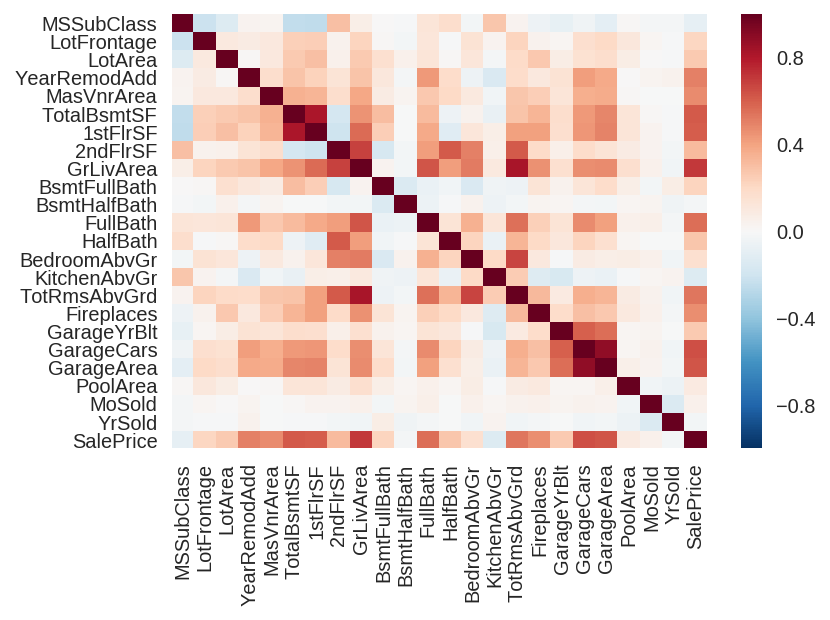

In [13]:
sns.heatmap(fixed.corr())

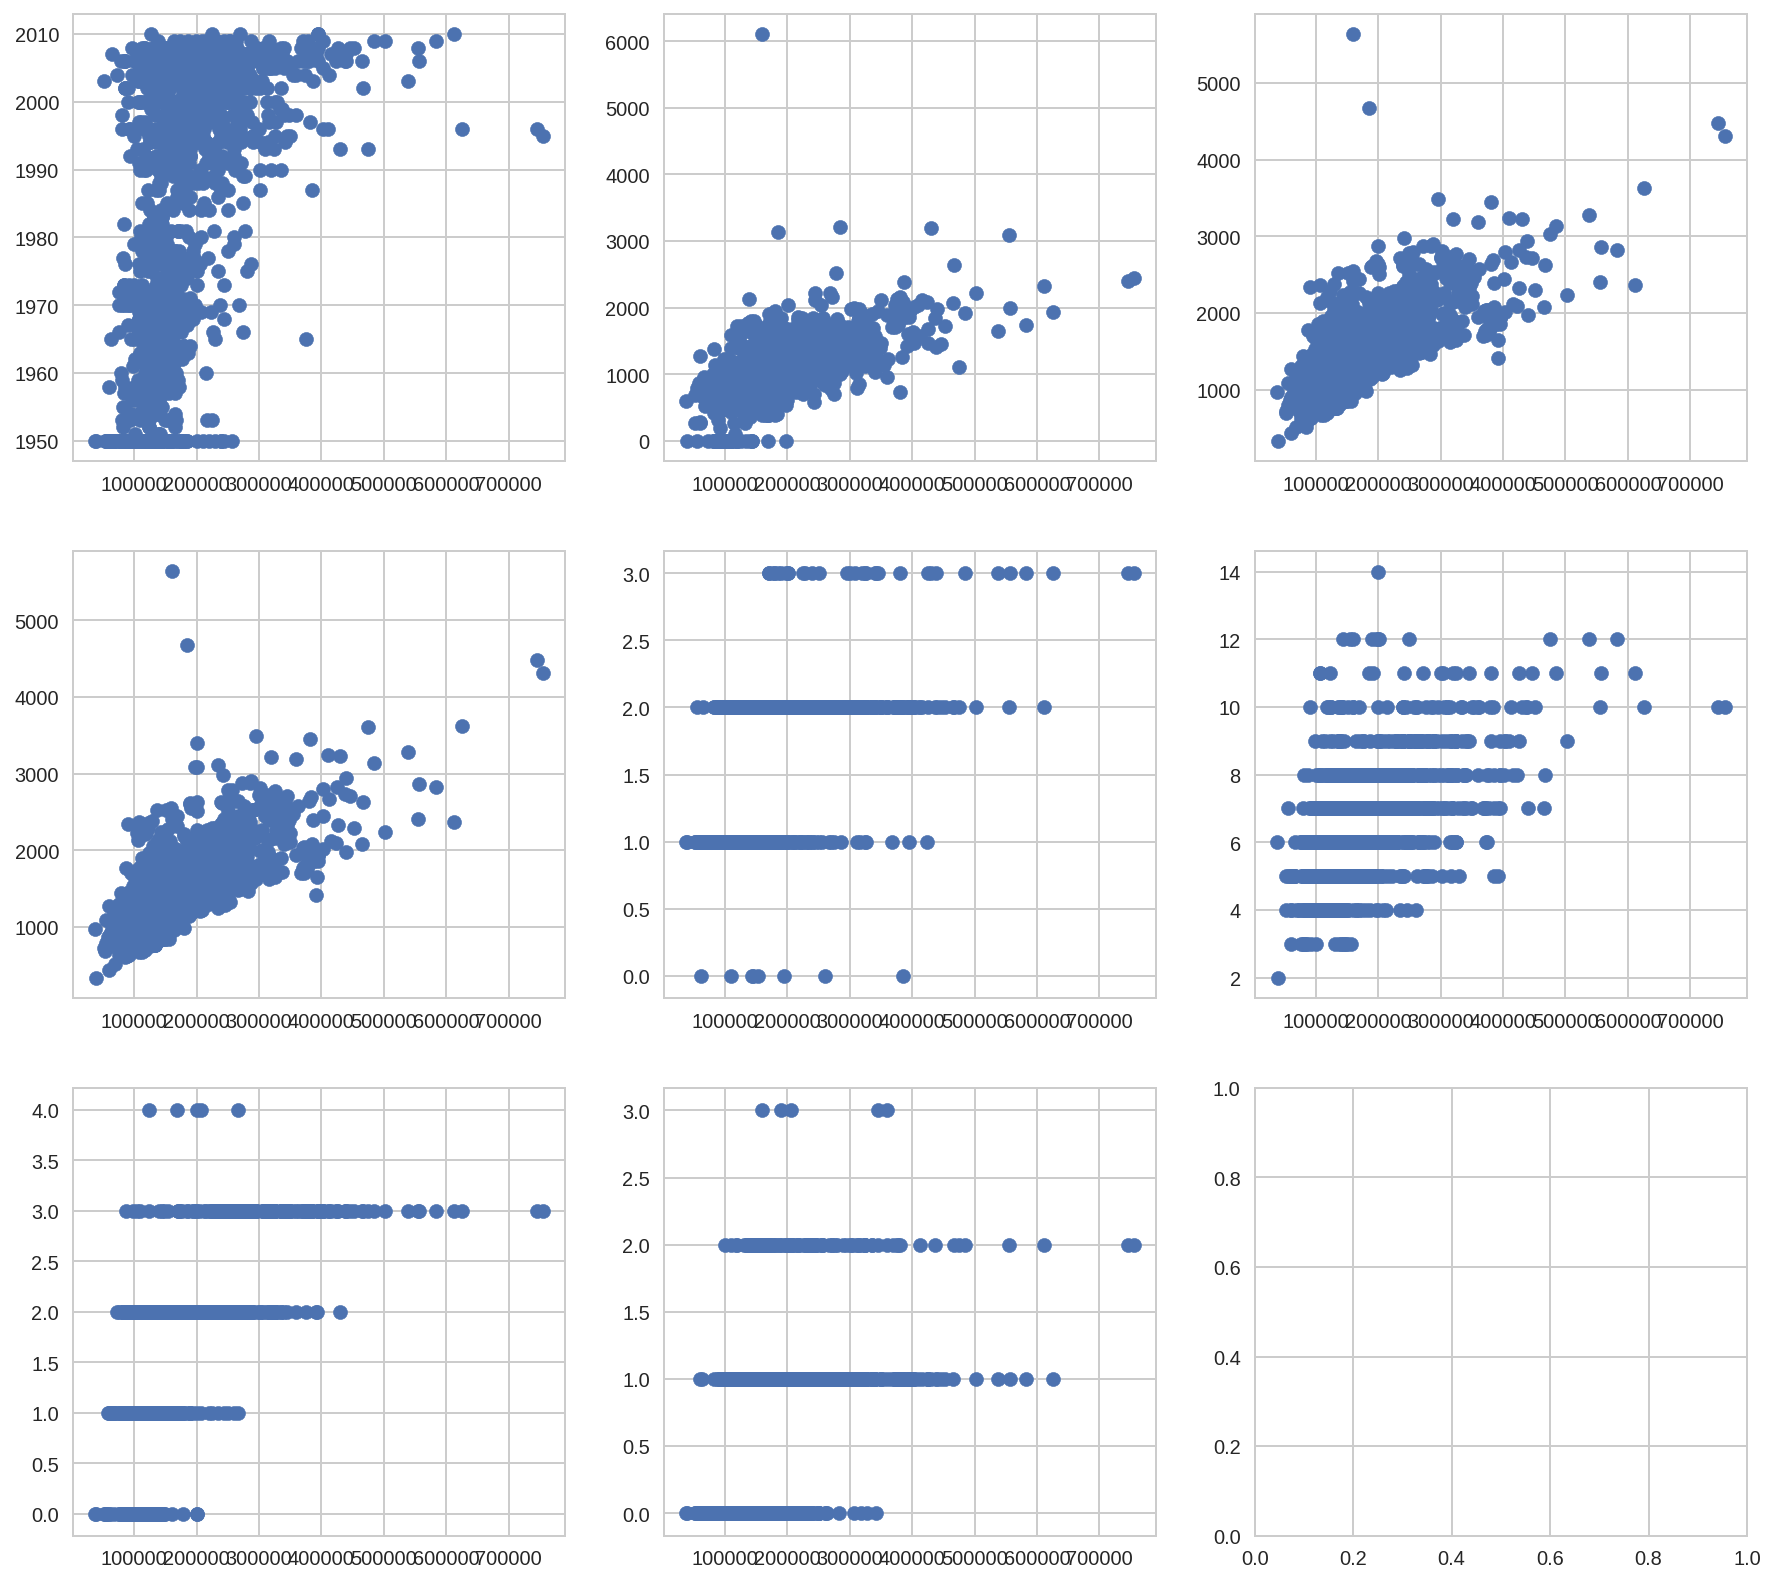

In [190]:
fig, ax = plt.subplots(3,3,figsize=(15,14))

ax[0,0].scatter(residential['SalePrice'], residential['YearRemodAdd'])
ax[0,1].scatter(residential['SalePrice'], residential['TotalBsmtSF'])
ax[0,2].scatter(residential['SalePrice'], residential['TotSF'])

ax[1,0].scatter(residential['SalePrice'], residential['GrLivArea'])
ax[1,1].scatter(residential['SalePrice'], residential['FullBath'])
ax[1,2].scatter(residential['SalePrice'], residential['TotRmsAbvGrd'])

ax[2,0].scatter(residential['SalePrice'], residential['GarageCars'])
ax[2,1].scatter(residential['SalePrice'], residential['Fireplaces'])


In [15]:
mask = ((fixed['TotalBsmtSF'] > 5000) | (fixed['1stFlrSF'] > 4000) | (fixed ['GrLivArea'] > 4000))
fixed[mask]

#the 4 rows below look like extreme outliers to me.  Going to drop them and re-draw heatmap

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,...,GarageType,GarageYrBlt,GarageCars,GarageArea,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NA,IR1,Bnk,Inside,Edwards,...,BuiltIn,2007.0,3,884,0,10,2007,New,Partial,184750
691,60,RL,104.0,21535,Pave,NA,IR1,Lvl,Corner,NoRidge,...,Attchd,1994.0,3,832,0,1,2007,WD,Normal,755000
1182,60,RL,160.0,15623,Pave,NA,IR1,Lvl,Corner,NoRidge,...,Attchd,1996.0,3,813,555,7,2007,WD,Abnorml,745000
1298,60,RL,313.0,63887,Pave,NA,IR3,Bnk,Corner,Edwards,...,Attchd,2008.0,2,1418,480,1,2008,New,Partial,160000


In [16]:
fixed.shape

(1450, 45)

In [17]:
fixed.drop([523,691,1182,1298],inplace = True)

In [18]:
fixed_d = pd.get_dummies(fixed, columns = [
'MSSubClass',       
'MSZoning',
'Street',           
'Alley',            
'LotShape',         
'LandContour',      
'LotConfig',        
'Neighborhood',     
'Condition1',       
'Condition2',       
'BldgType',         
'HouseStyle',       
'YearRemodAdd',     
'RoofStyle',        
'Exterior1st',      
'Exterior2nd',      
'MasVnrType',       
'Foundation',       
'BsmtQual',         
'BsmtExposure',     
'BsmtFullBath',     
'BsmtHalfBath',     
'FullBath',         
'HalfBath',         
'BedroomAbvGr',     
'KitchenAbvGr',     
'TotRmsAbvGrd',     
'Fireplaces',       
'GarageType',       
'GarageYrBlt',      
'GarageCars',       
'MoSold',           
'YrSold',           
'SaleType',         
'SaleCondition'   
])



In [19]:
mask = fixed_d['YrSold_2010']==1
fixed_test = pd.DataFrame(fixed_d[mask])
fixed_train =pd.DataFrame(fixed_d[~mask])

In [20]:
fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 45 columns):
MSSubClass       1446 non-null int64
MSZoning         1446 non-null object
LotFrontage      1446 non-null float64
LotArea          1446 non-null int64
Street           1446 non-null object
Alley            1446 non-null object
LotShape         1446 non-null object
LandContour      1446 non-null object
LotConfig        1446 non-null object
Neighborhood     1446 non-null object
Condition1       1446 non-null object
Condition2       1446 non-null object
BldgType         1446 non-null object
HouseStyle       1446 non-null object
YearRemodAdd     1446 non-null int64
RoofStyle        1446 non-null object
Exterior1st      1446 non-null object
Exterior2nd      1446 non-null object
MasVnrType       1446 non-null object
MasVnrArea       1446 non-null float64
Foundation       1446 non-null object
BsmtQual         1446 non-null object
BsmtExposure     1446 non-null object
TotalBsmtSF      144

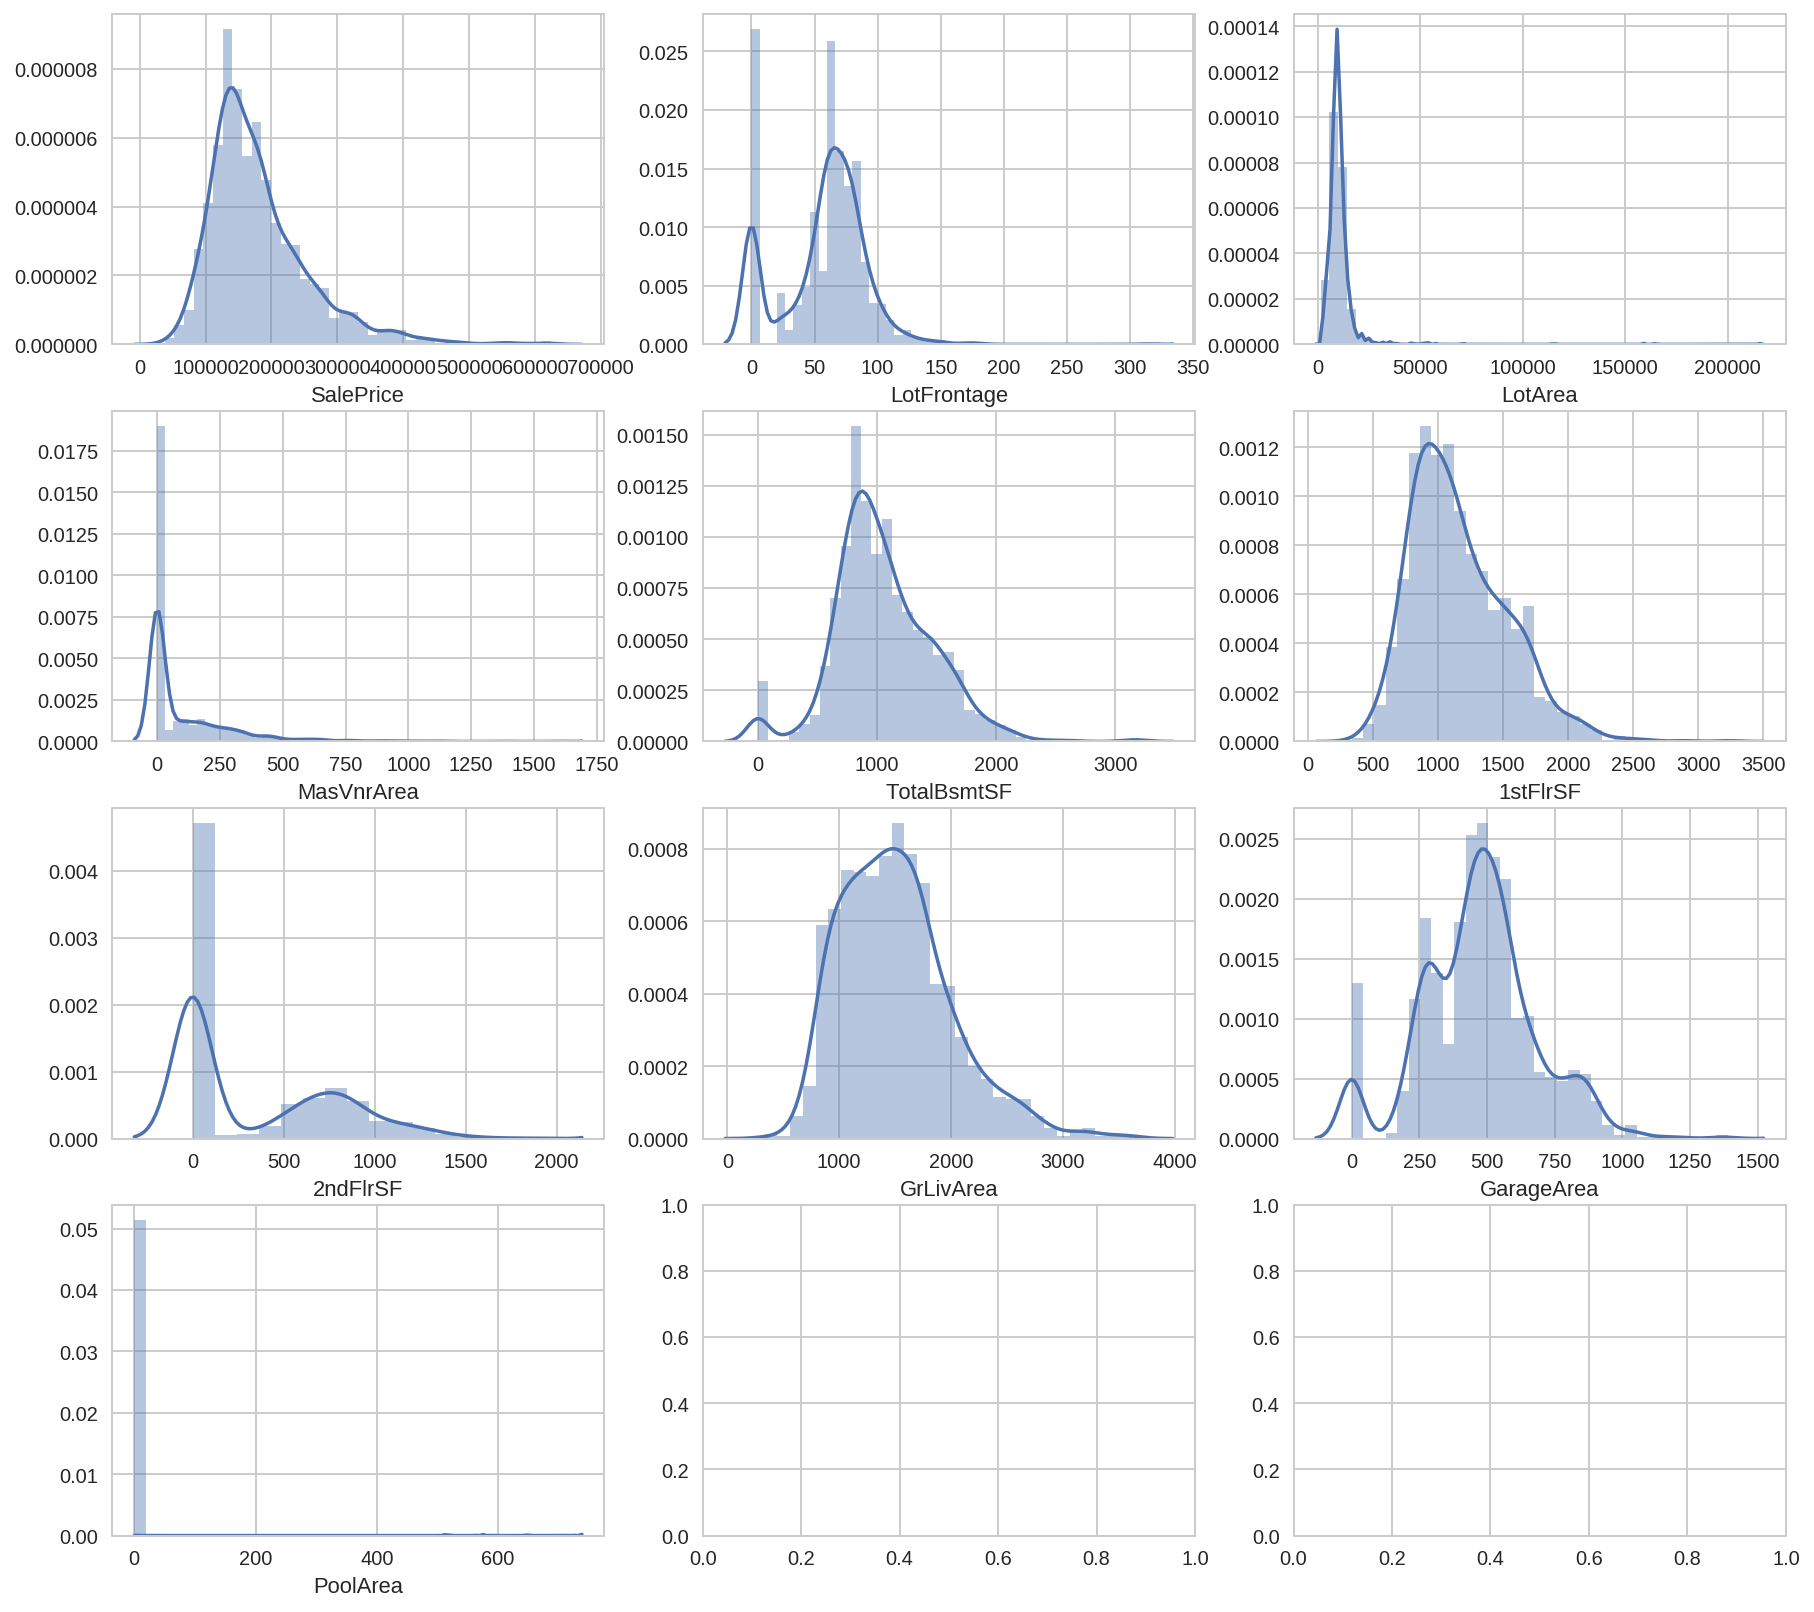

In [21]:

fig, ax = plt.subplots(4,3,figsize=(15,14))
sns.distplot(fixed['SalePrice'], ax= ax[0,0])
sns.distplot(fixed['LotFrontage'], ax= ax[0,1])
sns.distplot(fixed['LotArea'], ax= ax[0,2])

sns.distplot(fixed['MasVnrArea'], ax= ax[1,0])
sns.distplot(fixed['TotalBsmtSF'], ax= ax[1,1])
sns.distplot(fixed['1stFlrSF'], ax= ax[1,2])

sns.distplot(fixed['2ndFlrSF'], ax= ax[2,0])
sns.distplot(fixed['GrLivArea'], ax= ax[2,1])
sns.distplot(fixed['GarageArea'], ax= ax[2,2])

sns.distplot(fixed['PoolArea'], ax= ax[3,0])


In [22]:
#pool area distribution is horrcible.  probably causes more harm than good so dropping it. 
#MasnVnrArea looks pretty bad too and probably not very helpful in determining price so dropping it too.
#The other distributions don't look so good either. will perform skewtest next.
fixed_test.drop(['PoolArea','MasVnrArea'],axis = 1, inplace = True)
fixed_train.drop(['PoolArea','MasVnrArea'],axis = 1, inplace = True)

In [26]:
for col in continuous_list:    print('{} skew test: {}'.format(col, st.skewtest(fixed_train[col])))


LotFrontage skew test: SkewtestResult(statistic=0.54838936887445922, pvalue=0.5834245746406892)
LotArea skew test: SkewtestResult(statistic=41.272225943608646, pvalue=0.0)
TotalBsmtSF skew test: SkewtestResult(statistic=7.0329485264447422, pvalue=2.0221398235934089e-12)
1stFlrSF skew test: SkewtestResult(statistic=11.235683924581071, pvalue=2.7237636577781489e-29)
2ndFlrSF skew test: SkewtestResult(statistic=9.945658080628224, pvalue=2.6342708051526572e-23)
GrLivArea skew test: SkewtestResult(statistic=10.54593762546358, pvalue=5.3041120294791299e-26)
GarageArea skew test: SkewtestResult(statistic=2.2667453429878508, pvalue=0.023405786758751448)


In [797]:
#LotFrontage might be ok

In [48]:

col = 'LotArea'
box_cox_trans,the_val = st.boxcox(fixed_train[col])
print(the_val)
fixed_train[col+'_scaled']=np.log(fixed_train[col])
fixed_train[col+'_bc']=pd.Series(box_cox_trans)
print('{} skew test: {}'.format(col +'', st.skewtest(fixed_train[col])))
print('{} log skew test: {}'.format(col +'_scaled', st.skewtest(fixed_train[col+'_scaled'])))
print('{} box cox skew test: {}'.format(col +'_bc', st.skewtest(fixed_train[col+'_bc'])))

-8.470798811383702
LotArea skew test: SkewtestResult(statistic=41.272225943608646, pvalue=0.0)
LotArea_scaled log skew test: SkewtestResult(statistic=-2.0893236444464183, pvalue=0.036678599372660055)
LotArea_bc box cox skew test: SkewtestResult(statistic=nan, pvalue=nan)


/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:901: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1855: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - 

In [30]:
mask = (fixed_train['LotArea']==0)
fixed_train[mask].shape

(0, 402)

In [802]:
mask = (fixed_train['LotArea_scaled'].isnull())
fixed_train[mask].shape

(159, 402)

In [800]:
mask = (fixed_train['LotArea_scaled'].isnull())
fixed_train[mask].sort(['LotArea'],ascending = False)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,SalePrice,MSSubClass_20,MSSubClass_30,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotArea_scaled
1287,0.0,36500,1624,1582,0,1582,390,190000,1,0,...,0,0,1,0,0,0,0,1,0,NaN
1383,0.0,25339,816,1416,0,1416,576,112000,0,1,...,0,0,1,0,0,0,0,1,0,NaN
1430,60.0,21930,732,734,1104,1838,372,192140,0,0,...,0,0,1,0,0,0,0,1,0,NaN
1346,0.0,20781,1568,2156,0,2156,508,262500,1,0,...,0,0,1,0,0,0,0,1,0,NaN
1409,46.0,20544,791,1236,857,2093,542,215000,0,0,...,0,0,1,0,0,0,0,1,0,NaN
1423,0.0,19690,697,1575,626,2201,432,274970,0,0,...,0,0,1,0,0,1,0,0,0,NaN
1277,0.0,17871,1680,1724,0,1724,480,197900,0,0,...,0,0,1,0,0,0,0,1,0,NaN
1434,80.0,17400,1126,1126,0,1126,484,160000,1,0,...,0,0,1,0,0,0,0,1,0,NaN
1453,90.0,17217,1140,1140,0,1140,0,84500,1,0,...,0,0,1,1,0,0,0,0,0,NaN
1359,129.0,16737,1980,1980,0,1980,770,315000,1,0,...,0,0,1,0,0,0,0,1,0,NaN


In [701]:
fixed_train.shape

(1274, 401)

In [736]:
#box-cox to try and de-skew data
import scipy.stats as st
box_cox_trans = st.boxcox(fixed_train['LotArea'] )[0]
box_cox_trans
#for col in continuous_list:
#    box_cox_trans = st.boxcox(fixed_train[col]+2.0)[0]
#    fixed_train[col] = pd.Series(box_cox_trans)

array([ 0.11805262,  0.11805262,  0.11805262, ...,  0.11805262,
        0.11805262,  0.11805262])

In [737]:
fixed_train['lot_transformed']= box_cox_trans

In [738]:
st.skewtest(fixed_train['lot_transformed'])

SkewtestResult(statistic=1.0022887513853014, pvalue=0.31620415373522348)

In [730]:
st.skewtest(fixed_train['gr_transformed'])

SkewtestResult(statistic=-0.012183760712949103, pvalue=0.99027900593913076)

In [710]:
fixed_train.shape

(1274, 402)

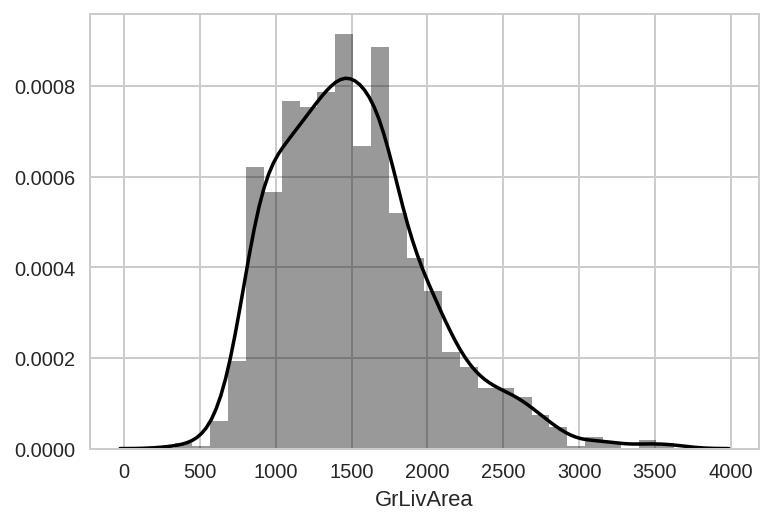

In [734]:
sns.distplot(fixed_train['GrLivArea'], color= 'black')
sns.distplot(fixed_train['gr_transformed'])


ValueError: cannot convert float NaN to integer

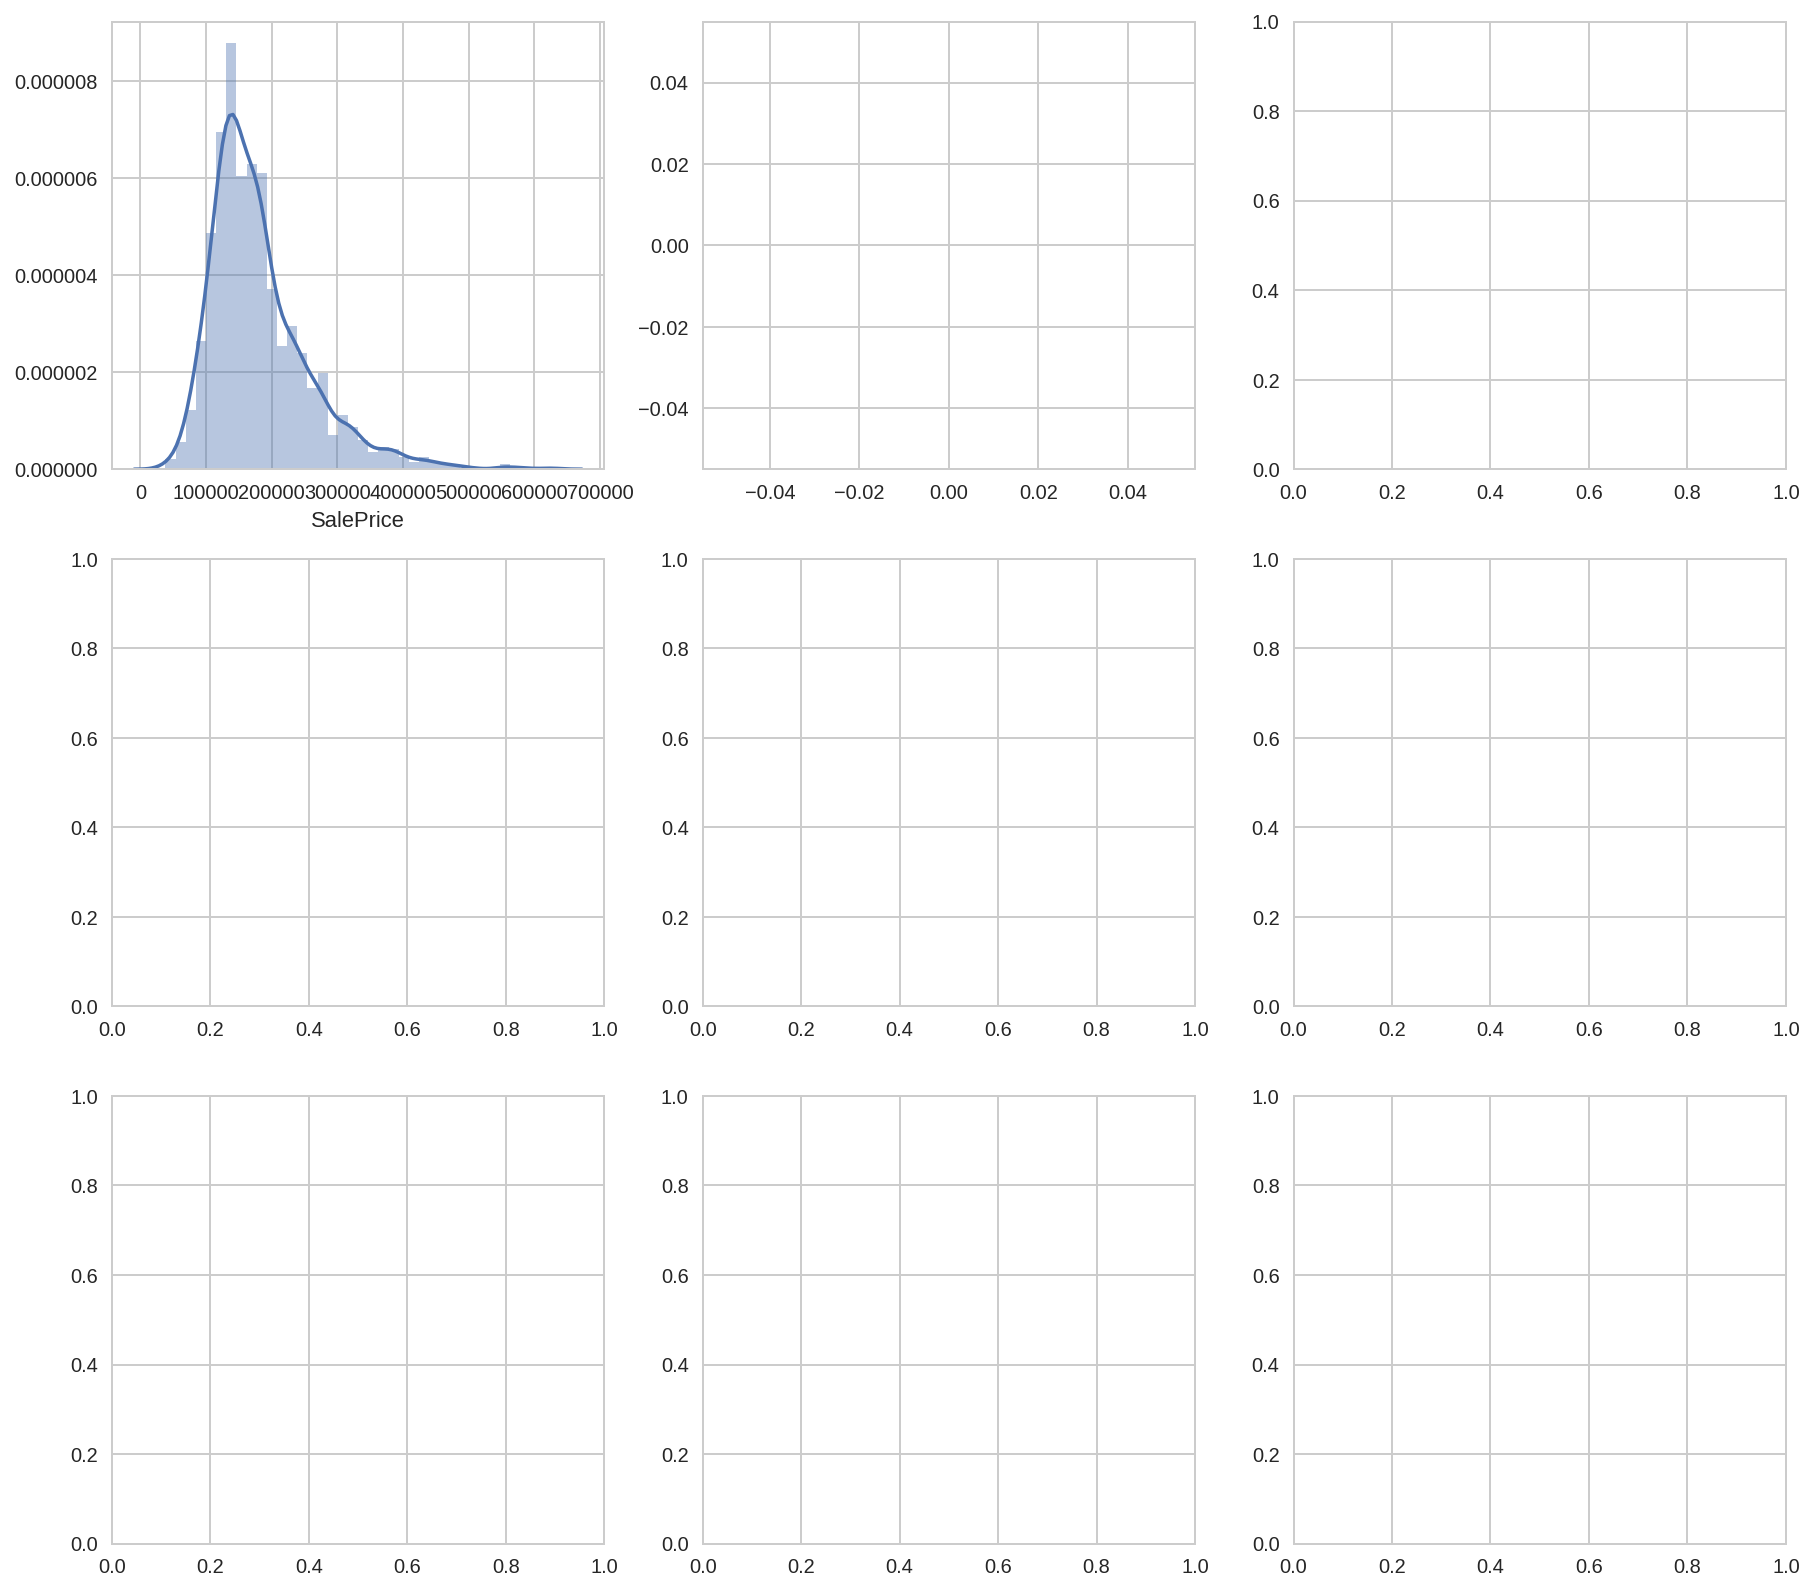

In [676]:
fig, ax = plt.subplots(3,3,figsize=(15,14))
sns.distplot(fixed_train['SalePrice'], ax= ax[0,0])
sns.distplot(fixed_train['LotFrontage'], ax= ax[0,1])
sns.distplot(fixed_train['LotArea'], ax= ax[0,2])

sns.distplot(fixed_train['TotalBsmtSF'], ax= ax[1,1])
sns.distplot(fixed_train['1stFlrSF'], ax= ax[1,2])

sns.distplot(fixed_train['2ndFlrSF'], ax= ax[2,0])
sns.distplot(fixed_train['GrLivArea'], ax= ax[2,1])
sns.distplot(fixed_train['GarageArea'], ax= ax[2,2])




In [466]:
fixed['BsmtFullBath'].unique()

array([1, 0, 2, 3])

In [456]:
fixed.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,...,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,PoolArea,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,Inside,CollgCr,...,0,Attchd,2003.0,2,548,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,FR2,Veenker,...,1,Attchd,1976.0,2,460,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,Inside,CollgCr,...,1,Attchd,2001.0,2,608,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,Corner,Crawfor,...,1,Detchd,1998.0,3,642,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,FR2,NoRidge,...,1,Attchd,2000.0,3,836,0,12,2008,WD,Normal


In [369]:
fixed = pd.DataFrame(residential)
renovate = pd.DataFrame(residential)

In [370]:
#u'GarageYrBlt',
fixed_cols_to_keep = [u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street',  u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'YearRemodAdd', 
        u'RoofStyle',u'Foundation', u'BsmtQual', 
        u'BsmtExposure',u'TotalBsmtSF',u'1stFlrSF',u'2ndFlrSF',  
        u'GrLivArea', u'BsmtFullBath',u'BsmtHalfBath', u'FullBath', 
        u'HalfBath', u'BedroomAbvGr',u'TotRmsAbvGrd',u'GarageType', 
         u'GarageCars', u'GarageArea',
        u'OpenPorchSF',u'EnclosedPorch', u'3SsnPorch', 
        u'PoolArea', u'MoSold', u'YrSold', u'SaleCondition', u'SalePrice']

fixed = residential.filter(fixed_cols_to_keep, axis = 1)

In [371]:
fixed.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCars,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,PoolArea,MoSold,YrSold,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2,548,61,0,0,0,2,2008,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,2,460,0,0,0,0,5,2007,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,2,608,42,0,0,0,9,2008,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,3,642,35,272,0,0,2,2006,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,3,836,84,0,0,0,12,2008,Normal,250000


In [372]:
fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 41 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
Foundation       1450 non-null object
BsmtQual         1450 non-null object
BsmtExposure     1450 non-null object
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
GrLivArea        1450 no

In [373]:
mask = (fixed['YrSold']==2010)
fixed_test = pd.DataFrame(fixed[mask])
fixed_train = pd.DataFrame(fixed[~(mask)])

fixed_test_y = fixed_test['SalePrice']
fixed_test_x = fixed_test.drop('SalePrice',axis =1)
fixed_train_y = fixed_train['SalePrice']
fixed_train_x= fixed_train.drop('SalePrice',axis = 1)

In [374]:
type(fixed_test_x)

pandas.core.frame.DataFrame

In [375]:
fixed_train_x.shape

(1278, 40)

In [445]:
#'GarageYrBlt',
fixed_test_x = pd.get_dummies(fixed_test_x, columns = [
'MSSubClass', 
'MSZoning',
'Street',
'LotShape',
'LandContour',
'Utilities',
'LotConfig',
'LandSlope',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearRemodAdd',
'RoofStyle',
'Foundation',
'BsmtQual',
'BsmtExposure',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'TotRmsAbvGrd',
'GarageType',
'GarageCars',
'MoSold',
'YrSold',
'SaleCondition'
])

ValueError: labels ['MSSubClass' 'MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'YearRemodAdd' 'RoofStyle' 'Foundation' 'BsmtQual'
 'BsmtExposure' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'TotRmsAbvGrd' 'GarageType' 'GarageCars' 'MoSold' 'YrSold'
 'SaleCondition'] not contained in axis

In [377]:
#'GarageYrBlt',
fixed_train_x = pd.get_dummies(fixed_train_x, columns = [
'MSSubClass', 
'MSZoning',
'Street',
'LotShape',
'LandContour',
'Utilities',
'LotConfig',
'LandSlope',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearRemodAdd',
'RoofStyle',
'Foundation',
'BsmtQual',
'BsmtExposure',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'TotRmsAbvGrd',
'GarageType',
'GarageCars',
'MoSold',
'YrSold',
'SaleCondition'
])

In [393]:
fixed_train_x.shape

(1278, 255)

In [379]:
fixed_test_x.shape

(172, 209)

In [380]:
fixed_train_y

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
25      256300
28      207500
29       68500
31      149350
32      179900
34      277500
35      309000
         ...  
1424    144000
1425    142000
1426    271000
1427    140000
1429    182900
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1459    147500
Name: SalePrice, dtype: int64

In [381]:
#create new dataframe for test and train data



In [382]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [383]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dtr', DecisionTreeRegressor(random_state=42))
])

In [384]:
ss = StandardScaler()
dtr = DecisionTreeRegressor(random_state=42)

In [385]:
fixed_train_x

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,...,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,856,856,854,1710,548,61,0,0,...,0,0,1,0,0,0,0,0,1,0
1,80.0,9600,1262,1262,0,1262,460,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,68.0,11250,920,920,866,1786,608,42,0,0,...,0,0,1,0,0,0,0,0,1,0
3,60.0,9550,756,961,756,1717,642,35,272,0,...,1,0,0,0,1,0,0,0,0,0
4,84.0,14260,1145,1145,1053,2198,836,84,0,0,...,0,0,1,0,0,0,0,0,1,0
5,85.0,14115,796,796,566,1362,480,30,0,320,...,0,0,0,1,0,0,0,0,1,0
6,75.0,10084,1686,1694,0,1694,636,57,0,0,...,0,1,0,0,0,0,0,0,1,0
7,0.0,10382,1107,1107,983,2090,484,204,228,0,...,0,0,0,1,0,0,0,0,1,0
8,51.0,6120,952,1022,752,1774,468,0,205,0,...,0,0,1,0,1,0,0,0,0,0
9,50.0,7420,991,1077,0,1077,205,4,0,0,...,0,0,1,0,0,0,0,0,1,0


In [386]:
ss.fit_transform(fixed_train_x)
fixed_train_x

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,...,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,856,856,854,1710,548,61,0,0,...,0,0,1,0,0,0,0,0,1,0
1,80.0,9600,1262,1262,0,1262,460,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,68.0,11250,920,920,866,1786,608,42,0,0,...,0,0,1,0,0,0,0,0,1,0
3,60.0,9550,756,961,756,1717,642,35,272,0,...,1,0,0,0,1,0,0,0,0,0
4,84.0,14260,1145,1145,1053,2198,836,84,0,0,...,0,0,1,0,0,0,0,0,1,0
5,85.0,14115,796,796,566,1362,480,30,0,320,...,0,0,0,1,0,0,0,0,1,0
6,75.0,10084,1686,1694,0,1694,636,57,0,0,...,0,1,0,0,0,0,0,0,1,0
7,0.0,10382,1107,1107,983,2090,484,204,228,0,...,0,0,0,1,0,0,0,0,1,0
8,51.0,6120,952,1022,752,1774,468,0,205,0,...,0,0,1,0,1,0,0,0,0,0
9,50.0,7420,991,1077,0,1077,205,4,0,0,...,0,0,1,0,0,0,0,0,1,0


In [387]:
dtr.fit(fixed_train_x, fixed_train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [389]:
column_importance = pd.DataFrame(zip(fixed_train_x.columns,dtr.feature_importances_))

In [390]:
column_importance.sort([1], ascending = False)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,0,1
231,GarageCars_3,0.378265
5,GrLivArea,0.238416
2,TotalBsmtSF,0.094088
177,BsmtQual_Ex,0.035816
179,BsmtQual_Gd,0.023917
181,BsmtQual_TA,0.023463
42,LotConfig_Corner,0.022149
199,HalfBath_1,0.018172
1,LotArea,0.017326
6,GarageArea,0.016054


In [392]:
dtr.score(fixed_test_x, fixed_test_y)

ValueError: Number of features of the model must match the input. Model n_features is 255 and input n_features is 209 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [78]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [79]:
# A: